In [ ]:
# pip install git+https://github.com/openai/CLIP.git torch torchvision ftfy regex tqdm
import os
import torch
# import clip # replaced with open_clip
import open_clip
import numpy as np
from typing import Dict, List, Tuple

@torch.no_grad()
def get_clip_text_embeddings(
    symbol_to_words: Dict[str, List[str]],
    model_name: str = "ViT-B/32",
    device: str = None,
    batch_size: int = 32,
    normalize: bool = True,
    save_csv_dir: str = None,   # e.g., "./embeddings_out"
) -> Dict[str, np.ndarray]:
    """
    Generate CLIP text embeddings for 10 words (or any number) per symbol.

    Returns:
        dict: symbol -> numpy array of shape (num_words, embed_dim)
              (L2-normalized across rows if normalize=True)
    """
    # Pick device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load CLIP
    # model, _ = clip.load(model_name, device=device, jit=False)
    model, _, preprocess = open_clip.create_model_and_transforms(model_name, device=device)
    tokenizer = open_clip.get_tokenizer(model_name)
    model.eval()

    out: Dict[str, np.ndarray] = {}

    # Create output dir if saving
    if save_csv_dir is not None:
        os.makedirs(save_csv_dir, exist_ok=True)

    for symbol, words in symbol_to_words.items():
        if len(words) == 0:
            out[symbol] = np.zeros((0, model.encode_text.shape[1]), dtype=np.float32) #model.text_projection.shape[1]
            continue

        # Batched tokenization/encoding
        embs = []
        for i in range(0, len(words), batch_size):
            batch = words[i:i+batch_size]
            # tokens = clip.tokenize(batch, truncate=True).to(device)  # (B, 77)
            tokens = tokenizer(batch).to(device)
            text_features = model.encode_text(tokens)                # (B, D)
            # CLIP returns features that are often normalized downstream; we’ll normalize later.
            embs.append(text_features)

        embs = torch.cat(embs, dim=0)  # (num_words, D)
        if normalize:
            embs = torch.nn.functional.normalize(embs, p=2, dim=1)

        arr = embs.detach().cpu().numpy().astype(np.float32)
        out[symbol] = arr

        # Optional: save CSV for each symbol
        if save_csv_dir is not None:
            # rows = embeddings; columns = dims
            np.savetxt(os.path.join(save_csv_dir, f"{symbol}.csv"), arr, delimiter=",")

    return out


# Provide exactly 10 words (or more/less) per symbol
symbols_to_words = {
    "Fire": [
        "fire","flame","spark","ember","blaze","inferno","torch","burn",
        "light","heat","energy","passion","destruction","phoenix","eruption","fury",
        "illumination","ignition","wildfire","transformation","scorch","smolder","pyre","candle",
        "lava","hellfire","incineration","kindle","glow","furnace","molten","sacrifice",
        "desire","rage","volcano","radiance","sun","forge","purification","alchemy",
        "fuel","sacred","trial","consumption","red","danger","warmth","vision",
        "resurrection","creative","zeal","courage"
    ],
    "Air": [
        "air","wind","breeze","gust","draft","current","oxygen","breath",
        "sky","atmosphere","cloud","whisper","freedom","spirit","song","flight",
        "storm","movement","invisible","ethereal","whirl","zephyr","hurricane","cyclone",
        "whirlwind","clarity","exhalation","inspiration","communication","thought","idea","voice",
        "sound","music","vibration","aether","exchange","space","expansion","messenger",
        "swift","stormy","howl","north","intellect","clarion","transience","weightless",
        "immaterial","dissolution","awakening","mind"
    ],
    "Water": [
        "water","river","ocean","rain","stream","lake","wave","current",
        "tide","spring","pool","flow","storm","ice","mist","dew",
        "purification","life","depth","fluidity","fountain","drop","flood","tsunami",
        "erosion","tears","healing","reflection","mirror","cleansing","nourishment","birth",
        "moisture","well","bay","delta","foam","brine","salt","drift",
        "submersion","immersion","stillness","ebb","undercurrent","change","dream","intuitive",
        "surrender","emotion"
    ],
    "Earth": [
        "earth","soil","ground","clay","stone","rock","mountain","valley",
        "field","forest","fertility","foundation","stability","harvest","terrain","cave",
        "root","body","material","nourishment","dust","plateau","boulder","sand",
        "minerals","ore","metal","weight","mass","strength","gravitas","endurance",
        "growth","life","germination","seed","crop","plain","hill","meadow",
        "nature","womb","abundance","protection","dwelling","ancestry","support","permanence",
        "matter","depth"
    ]
}



embeddings_dict = get_clip_text_embeddings(
    symbols_to_words,
    model_name="ViT-B-32",     # or "ViT-L/14" if you prefer (heavier)
    device=None,               # auto-selects CUDA if available
    batch_size=32,
    normalize=True,
    save_csv_dir="./clip_symbol_embs"  # or None to skip saving
)

# Example: check shapes and use with your PH visualization pipeline
for sym, arr in embeddings_dict.items():
    print(sym, arr.shape)  # e.g., (10, 512) for ViT-B/32


Fire (52, 512)
Air (52, 512)
Water (50, 512)
Earth (50, 512)


In [21]:
# =========================
# Persistent-homology utils
# =========================
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from typing import Dict, Tuple

# ---- helpers
def _ensure_2d(X: np.ndarray) -> np.ndarray:
    X = np.asarray(X, dtype=float)
    if X.ndim != 2:
        raise ValueError("Embeddings must be a 2D array [n_points, n_dims].")
    # (re)normalize rows just in case
    norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    return X / norms

def _pairwise_dists(X: np.ndarray, metric: str = "euclidean") -> np.ndarray:
    X = _ensure_2d(X)
    if metric == "euclidean":
        diff = X[:, None, :] - X[None, :, :]
        return np.sqrt(np.sum(diff * diff, axis=2))
    elif metric == "cosine":
        S = X @ X.T
        S = np.clip(S, -1.0, 1.0)
        return 1.0 - S
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'")

# ---- H0 via MST (fast single-linkage lifetimes)
class _UF:
    def __init__(self, n):
        self.p = list(range(n)); self.r = [0]*n
    def f(self, x):
        while self.p[x] != x:
            self.p[x] = self.p[self.p[x]]; x = self.p[x]
        return x
    def u(self, a, b):
        ra, rb = self.f(a), self.f(b)
        if ra == rb: return False
        if self.r[ra] < self.r[rb]: self.p[ra] = rb
        elif self.r[ra] > self.r[rb]: self.p[rb] = ra
        else: self.p[rb] = ra; self.r[ra] += 1
        return True

def h0_bar_lengths_from_mst(X: np.ndarray, metric: str = "euclidean") -> np.ndarray:
    D = _pairwise_dists(X, metric=metric)
    n = len(X)
    edges = [(D[i, j], i, j) for i in range(n) for j in range(i+1, n)]
    edges.sort(key=lambda t: t[0])
    uf = _UF(n)
    lengths = []
    for w, i, j in edges:
        if uf.u(i, j):
            lengths.append(float(w))
            if len(lengths) == n-1:
                break
    return np.array(lengths)

def plot_h0_barcode_from_mst(lengths: np.ndarray, title: str):
    order = np.argsort(lengths)
    plt.figure(figsize=(8, 4))
    for k, idx in enumerate(order):
        L = float(lengths[idx])
        plt.hlines(k, 0.0, L)
    plt.xlabel("Scale (ε)")
    plt.ylabel("Component index (sorted)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---- Rips persistent homology (ripser -> fallback)
def _vr_filtration_simplices_up_to3(D: np.ndarray):
    n = len(D)
    simplices = []
    # 0-simplices
    for i in range(n):
        simplices.append((0.0, 0, (i,)))
    # 1-simplices
    for i, j in combinations(range(n), 2):
        simplices.append((float(D[i, j]), 1, (i, j)))
    # 2-simplices (triangles)
    def tri_birth(i, j, k):
        return max(float(D[i, j]), float(D[i, k]), float(D[j, k]))
    for i, j, k in combinations(range(n), 3):
        simplices.append((tri_birth(i, j, k), 2, (i, j, k)))
    # 3-simplices (tetrahedra)
    def tetra_birth(i, j, k, l):
        idx = [i, j, k, l]
        m = 0.0
        for a, b in combinations(idx, 2):
            m = max(m, float(D[a, b]))
        return m
    for i, j, k, l in combinations(range(n), 4):
        simplices.append((tetra_birth(i, j, k, l), 3, (i, j, k, l)))
    simplices.sort(key=lambda t: (t[0], t[1]))
    return simplices

def _boundary_faces(simplex):
    s = list(simplex)
    return [tuple(s[:k] + s[k+1:]) for k in range(len(s))]

def _persistent_pairs_fallback(D: np.ndarray, max_return_dim=2):
    simplices = _vr_filtration_simplices_up_to3(D)
    m = len(simplices)
    index = {simplices[i][2]: i for i in range(m)}
    boundary = [set() for _ in range(m)]
    births = [simplices[i][0] for i in range(m)]
    for j, (_, dim, verts) in enumerate(simplices):
        if dim == 0: 
            continue
        for face in _boundary_faces(verts):
            boundary[j].add(index[face])

    low = {}
    paired = [False]*m
    dgms = {d: [] for d in range(max_return_dim+1)}

    def low_row(j):
        return max(boundary[j]) if boundary[j] else None

    for j in range(m):
        if simplices[j][1] == 0:
            continue
        lr = low_row(j)
        while lr is not None and lr in low:
            boundary[j] ^= boundary[low[lr]]
            lr = low_row(j)
        if lr is not None:
            i = lr
            birth = births[i]
            death = births[j]
            dim_class = simplices[i][1]
            if dim_class <= max_return_dim:
                dgms[dim_class].append((birth, death))
            low[lr] = j
            paired[i] = True; paired[j] = True

    for idx, (b, dim, _) in enumerate(simplices):
        if not paired[idx] and dim <= max_return_dim:
            dgms[dim].append((b, np.inf))

    for d in dgms:
        arr = np.array(dgms[d], dtype=float) if dgms[d] else np.zeros((0, 2))
        dgms[d] = arr
    return dgms

def compute_persistent_homology(X: np.ndarray, metric: str = "euclidean", maxdim: int = 2):
    X = _ensure_2d(X)
    try:
        from ripser import ripser
        out = ripser(X, maxdim=maxdim, metric=metric)
        dgms = out["dgms"]
        return {0: dgms[0], 1: dgms[1], 2: dgms[2] if maxdim >= 2 else np.zeros((0, 2))}, "ripser"
    except Exception:
        D = _pairwise_dists(X, metric=metric)
        return _persistent_pairs_fallback(D, max_return_dim=maxdim), "fallback"

# ---- plotting: PCA / PD / persistence image
def pca_2d(X: np.ndarray) -> np.ndarray:
    X = _ensure_2d(X)
    Xc = X - X.mean(0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    return Xc @ Vt[:2].T

def plot_pca_scatter(X: np.ndarray, title: str):
    Z = pca_2d(X)
    plt.figure(figsize=(5, 5))
    plt.scatter(Z[:, 0], Z[:, 1], s=14)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

def plot_persistence_diagram(dgms: Dict[int, np.ndarray], title: str):
    vmax = 0.0
    for arr in dgms.values():
        if arr.size:
            finite = np.where(np.isfinite(arr[:, 1]), arr[:, 1], arr[:, 0] + 0.1)
            vmax = max(vmax, float(np.max(finite)))
    vmax = max(vmax, 1.0)
    plt.figure(figsize=(7, 6))
    for h in sorted(dgms.keys()):
        arr = dgms[h]
        if arr.size:
            y = np.where(np.isfinite(arr[:, 1]), arr[:, 1], vmax)
            plt.scatter(arr[:, 0], y, s=18, label=f"H{h}")
    plt.plot([0, vmax], [0, vmax], linestyle="--", linewidth=1)
    plt.xlabel("Birth")
    plt.ylabel("Death (∞ truncated)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def _persistence_image(dgm: np.ndarray, res: int = 30) -> np.ndarray:
    if dgm.size == 0:
        return np.zeros((res, res))
    pts = np.copy(dgm)
    pts[:, 1] = pts[:, 1] - pts[:, 0]  # persistence
    finite = np.isfinite(pts[:, 1])
    pts = pts[finite]
    if pts.size == 0:
        return np.zeros((res, res))
    xb = np.linspace(0, float(np.max(pts[:, 0]) + 1e-9), res + 1)
    yb = np.linspace(0, float(np.max(pts[:, 1]) + 1e-9), res + 1)
    img = np.zeros((res, res))
    for x, y in pts:
        xi = np.searchsorted(xb, x) - 1
        yi = np.searchsorted(yb, y) - 1
        if 0 <= xi < res and 0 <= yi < res:
            img[yi, xi] += 1.0
    return img

def plot_persistence_image(dgm: np.ndarray, title: str, res: int = 30):
    img = _persistence_image(dgm, res=res)
    plt.figure(figsize=(5, 4))
    plt.imshow(img, origin="lower", aspect="auto")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---- numeric summaries per symbol
# --- 1) Summaries: now includes H2 as well ---
def _summarize_diagrams(symbol: str, dgms: Dict[int, np.ndarray], thr: float = 0.02) -> Dict[str, float]:
    row = {"symbol": symbol}

    # H0 (cohesion / outlierness)
    H0 = dgms.get(0, np.zeros((0, 2)))
    if H0.size and np.isfinite(H0[:,1]).any():
        finite0 = H0[np.isfinite(H0[:,1])]
        pers0 = finite0[:,1] - finite0[:,0]
        row.update({"H0_median": float(np.median(pers0)), "H0_max": float(np.max(pers0))})
    else:
        row.update({"H0_median": 0.0, "H0_max": 0.0})

    # H1 (loopiness)
    H1 = dgms.get(1, np.zeros((0, 2)))
    if H1.size and np.isfinite(H1[:,1]).any():
        finite1 = H1[np.isfinite(H1[:,1])]
        pers1 = finite1[:,1] - finite1[:,0]
        row.update({
            "H1_sum": float(np.sum(pers1)),
            "H1_max": float(np.max(pers1)),
            "H1_count_gt_thr": int(np.sum(pers1 > thr))
        })
    else:
        row.update({"H1_sum": 0.0, "H1_max": 0.0, "H1_count_gt_thr": 0})

    # H2 (voids/cavities)
    H2 = dgms.get(2, np.zeros((0, 2)))
    if H2.size and np.isfinite(H2[:,1]).any():
        finite2 = H2[np.isfinite(H2[:,1])]
        pers2 = finite2[:,1] - finite2[:,0]
        row.update({
            "H2_sum": float(np.sum(pers2)),
            "H2_max": float(np.max(pers2)),
            "H2_count_gt_thr": int(np.sum(pers2 > thr))
        })
    else:
        row.update({"H2_sum": 0.0, "H2_max": 0.0, "H2_count_gt_thr": 0})

    return row

def reduce_pcs(X, n_pcs=None):
    X = np.asarray(X, float)
    if n_pcs is None:  # full embeddings
        return X
    Xc = X - X.mean(0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    Z = Xc @ Vt[:n_pcs].T
    # re-normalize rows to keep cosine≈euclid behavior
    Z /= (np.linalg.norm(Z, axis=1, keepdims=True) + 1e-12)
    return Z

# =========================
# 1) Per-symbol plots API
# =========================
# --- 2) Per-symbol plots: add optional H2 image ---
def plot_symbolwise_PH(
    symbol_to_embeddings: Dict[str, np.ndarray],
    metric: str = "euclidean",
    maxdim: int = 2,
    persistence_image_res: int = 30,
    show_h2_image: bool = True
):
    """
    For each symbol:
      - PCA scatter
      - H0 barcode (MST)
      - Persistence diagram (H0..Hmaxdim)
      - Persistence image for H1 (if present)
      - [NEW] Persistence image for H2 if show_h2_image=True and H2 present
    """
    summaries = []
    for symbol, X in symbol_to_embeddings.items():
        X = _ensure_2d(X)
        X = reduce_pcs(X, n_pcs=10)
        plot_pca_scatter(X, f"{symbol} — PCA scatter")
        lengths = h0_bar_lengths_from_mst(X, metric=metric)
        plot_h0_barcode_from_mst(lengths, f"{symbol} — H0 barcode via MST")
        dgms, src = compute_persistent_homology(X, metric=metric, maxdim=maxdim)
        plot_persistence_diagram(dgms, f"{symbol} — Persistence diagram (source: {src})")
        if maxdim >= 1 and dgms[1].size:
            plot_persistence_image(dgms[1], f"{symbol} — Persistence image (H1)", res=persistence_image_res)
        if show_h2_image and maxdim >= 2 and dgms[2].size:
            plot_persistence_image(dgms[2], f"{symbol} — Persistence image (H2)", res=persistence_image_res)
        summaries.append(_summarize_diagrams(symbol, dgms))
    return summaries


# =========================
# 2) Cross-symbol comparison
# =========================
# --- 3) Cross-symbol comparison: add H2 bars & a H1-vs-H2 map ---
def plot_comparative_PH(
    symbol_to_embeddings: Dict[str, np.ndarray],
    metric: str = "euclidean",
    thr: float = 0.02
):
    """
    Produces cross-symbol charts:
      - H0_median (cohesion)
      - H0_max (outlierness)
      - H1_sum (loopiness) + H1_count_gt_thr
      - [NEW] H2_sum (voids) + H2_count_gt_thr
      - 2D map: Cohesion vs Loopiness
      - [NEW] 2D map: H1 (loopiness) vs H2 (voidiness)
    """
    import pandas as pd
    rows = []
    for sym, X in symbol_to_embeddings.items():
        X = _ensure_2d(X)
        X = reduce_pcs(X, n_pcs=10)
        dgms, _ = compute_persistent_homology(X, metric=metric, maxdim=2)
        rows.append(_summarize_diagrams(sym, dgms, thr=thr))
    df = pd.DataFrame(rows)
    symbols = df["symbol"].values

    # H0 cohesion
    plt.figure(); plt.bar(symbols, df["H0_median"].values)
    plt.ylabel("H0 median persistence (cohesion)"); plt.title("Cohesion by symbol (lower=tighter)")
    plt.xticks(rotation=20); plt.tight_layout(); plt.show()

    # H0 outlierness
    plt.figure(); plt.bar(symbols, df["H0_max"].values)
    plt.ylabel("H0 max persistence (outlierness)"); plt.title("Outlierness by symbol")
    plt.xticks(rotation=20); plt.tight_layout(); plt.show()

    # H1 loopiness
    plt.figure(); plt.bar(symbols, df["H1_sum"].values)
    plt.ylabel("H1 sum of persistences"); plt.title("Loopiness by symbol (H1 total)")
    plt.xticks(rotation=20); plt.tight_layout(); plt.show()

    plt.figure(); plt.bar(symbols, df["H1_count_gt_thr"].values)
    plt.ylabel(f"H1 count (> {thr})"); plt.title("Number of 'significant' H1 loops")
    plt.xticks(rotation=20); plt.tight_layout(); plt.show()

    # [NEW] H2 voidiness
    plt.figure(); plt.bar(symbols, df["H2_sum"].values)
    plt.ylabel("H2 sum of persistences"); plt.title("Voidiness by symbol (H2 total)")
    plt.xticks(rotation=20); plt.tight_layout(); plt.show()

    plt.figure(); plt.bar(symbols, df["H2_count_gt_thr"].values)
    plt.ylabel(f"H2 count (> {thr})"); plt.title("Number of 'significant' H2 voids")
    plt.xticks(rotation=20); plt.tight_layout(); plt.show()

    # 2D maps
    plt.figure()
    x = df["H0_median"].values; y = df["H1_sum"].values
    plt.scatter(x, y)
    for i, s in enumerate(symbols):
        plt.annotate(s, (x[i], y[i]), xytext=(5, 5), textcoords="offset points")
    plt.xlabel("Cohesion (H0 median) — lower is tighter")
    plt.ylabel("Loopiness (H1 sum)")
    plt.title("Symbol map: Cohesion vs Loopiness (H1)")
    plt.tight_layout(); plt.show()

    plt.figure()
    x = df["H1_sum"].values; y = df["H2_sum"].values
    plt.scatter(x, y)
    for i, s in enumerate(symbols):
        plt.annotate(s, (x[i], y[i]), xytext=(5, 5), textcoords="offset points")
    plt.xlabel("Loopiness (H1 sum)")
    plt.ylabel("Voidiness (H2 sum)")
    plt.title("Symbol map: H1 vs H2")
    plt.tight_layout(); plt.show()

    return df


# =========================
# Convenience switch
# =========================
def plot_symbols(
    symbol_to_embeddings: Dict[str, np.ndarray],
    mode: str = "per-symbol",
    metric: str = "euclidean",
    **kwargs
):
    """
    mode='per-symbol' -> calls plot_symbolwise_PH(...)
    mode='compare'    -> calls plot_comparative_PH(...)
    """
    if mode == "per-symbol":
        return plot_symbolwise_PH(symbol_to_embeddings, metric=metric, **kwargs)
    elif mode == "compare":
        return plot_comparative_PH(symbol_to_embeddings, metric=metric, **kwargs)
    else:
        raise ValueError("mode must be 'per-symbol' or 'compare'")


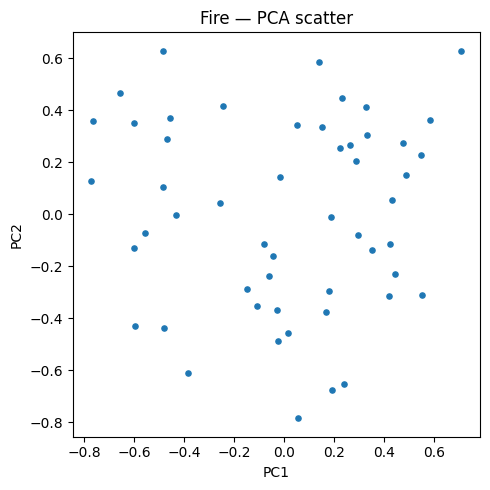

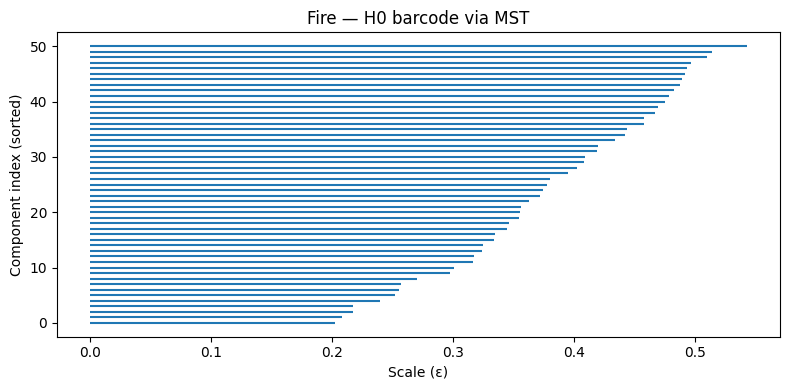

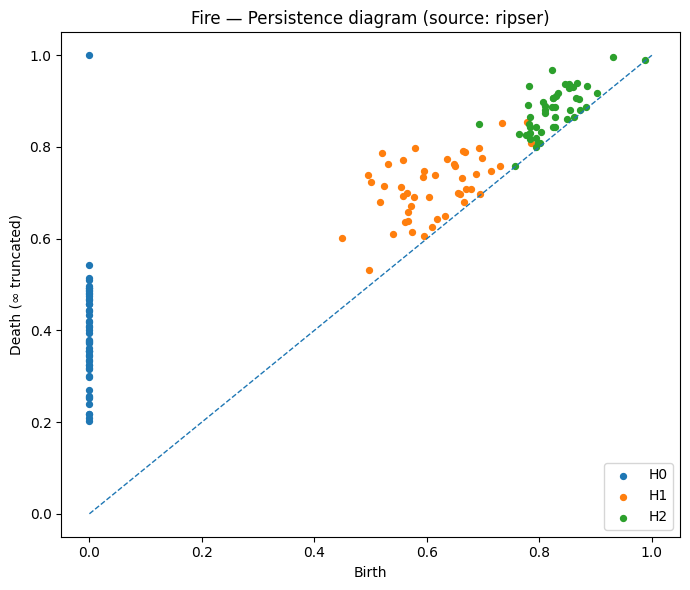

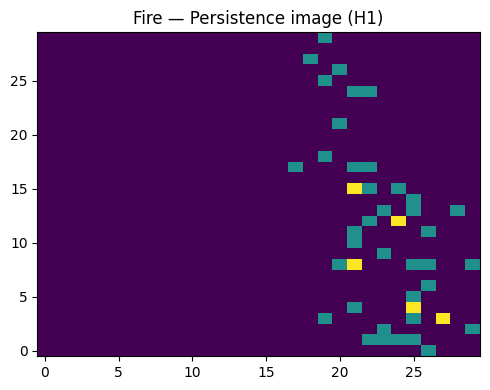

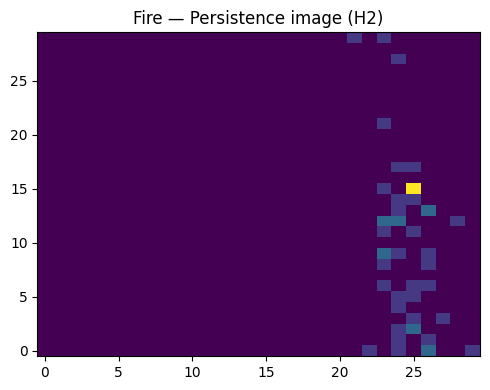

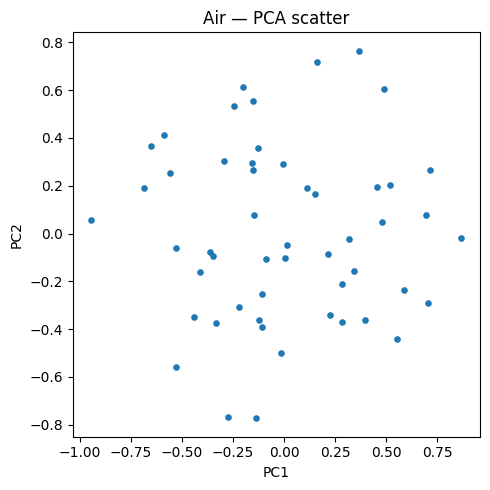

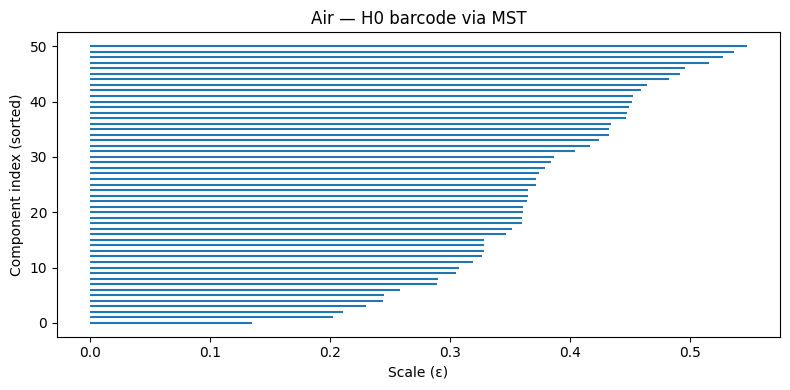

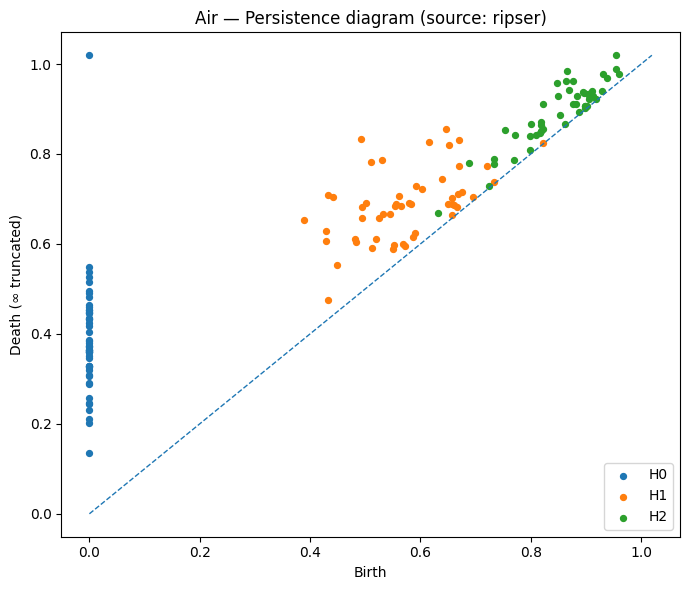

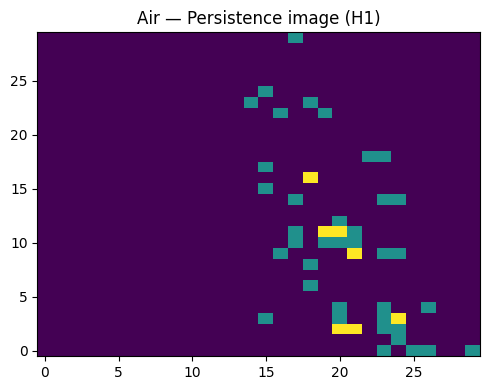

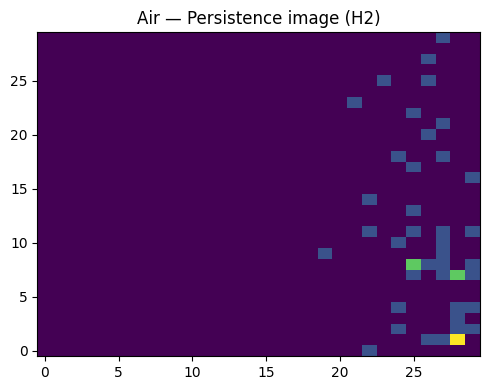

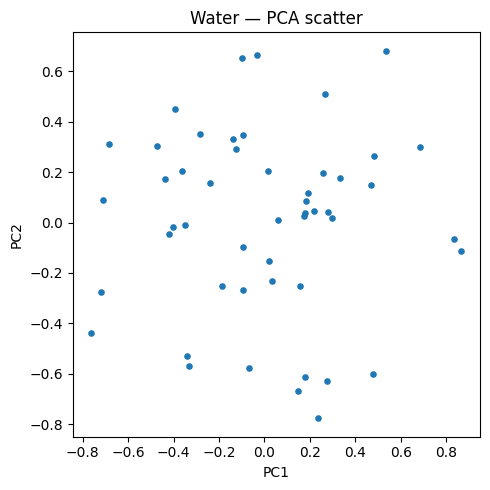

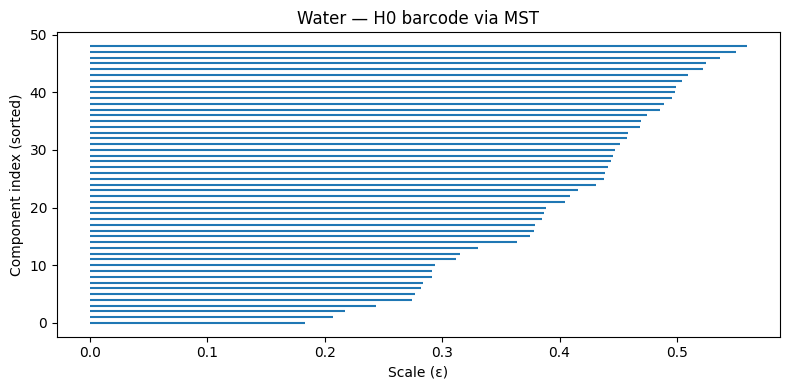

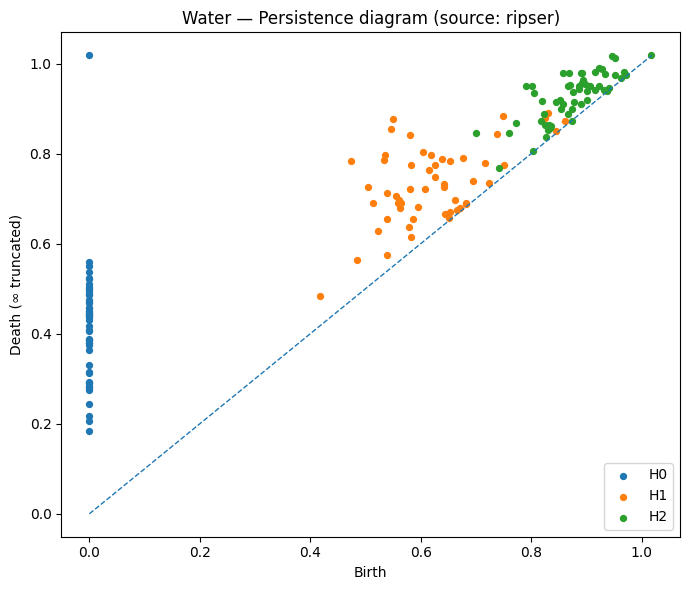

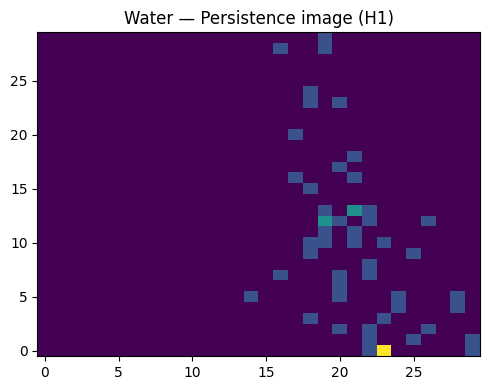

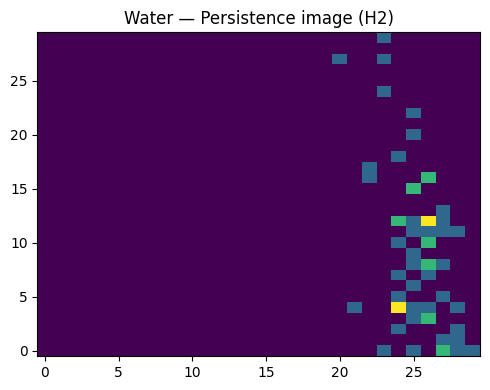

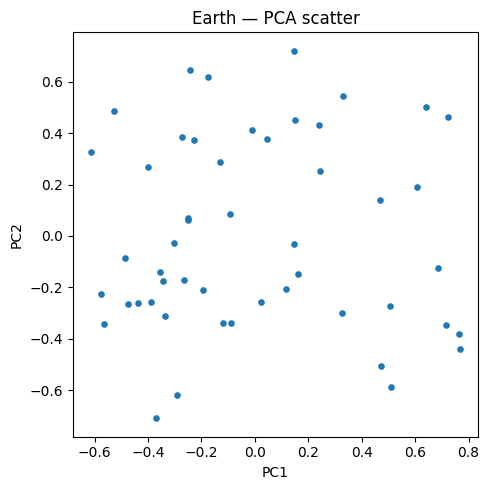

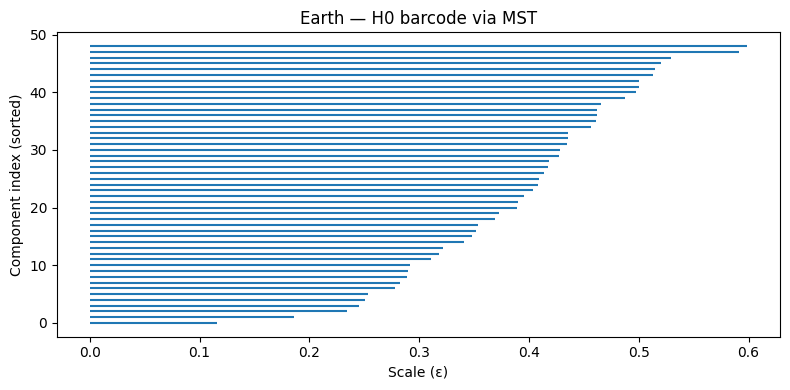

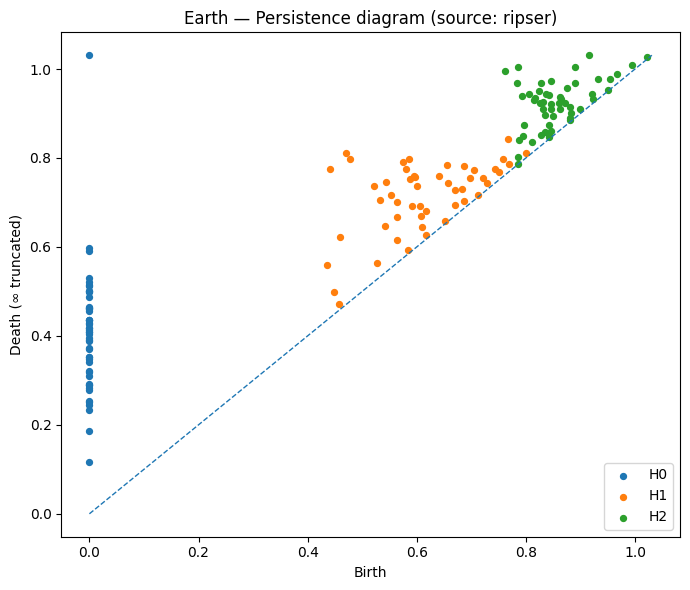

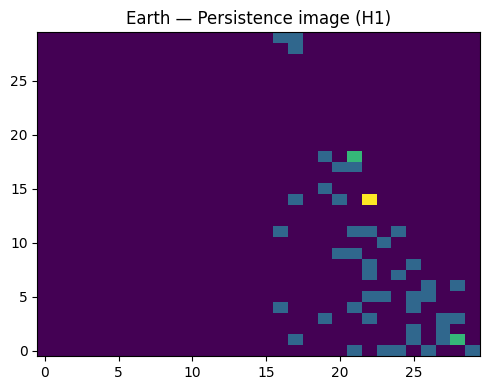

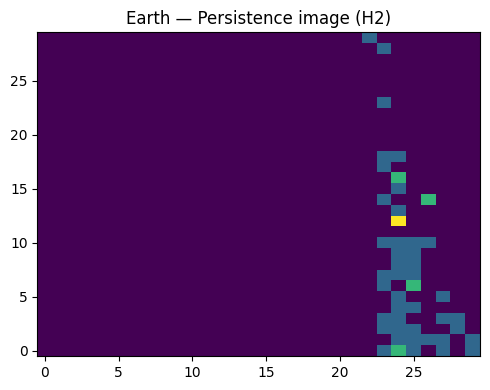

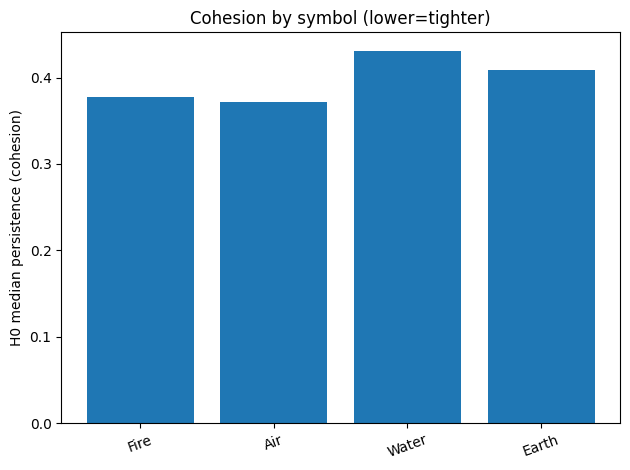

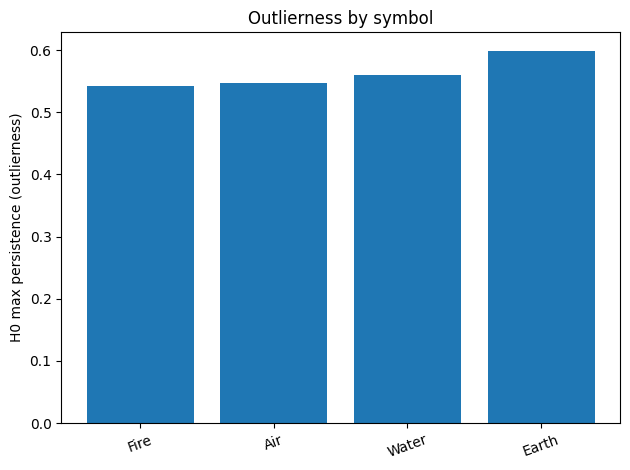

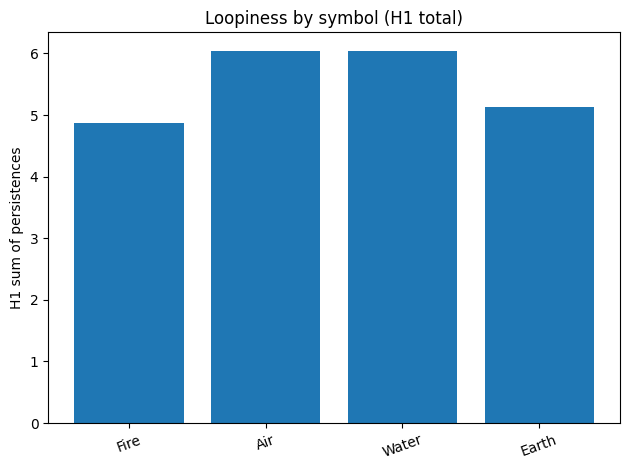

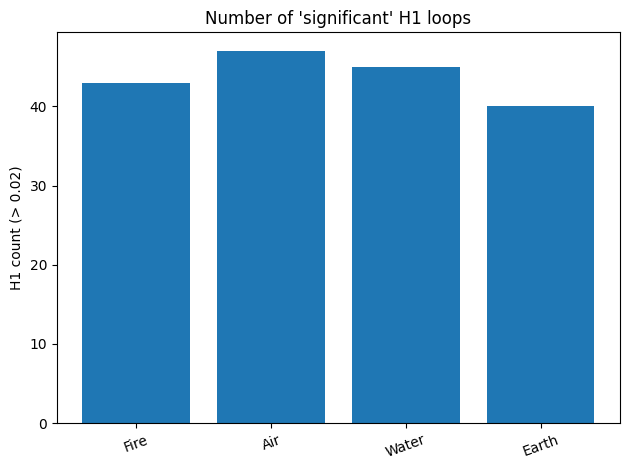

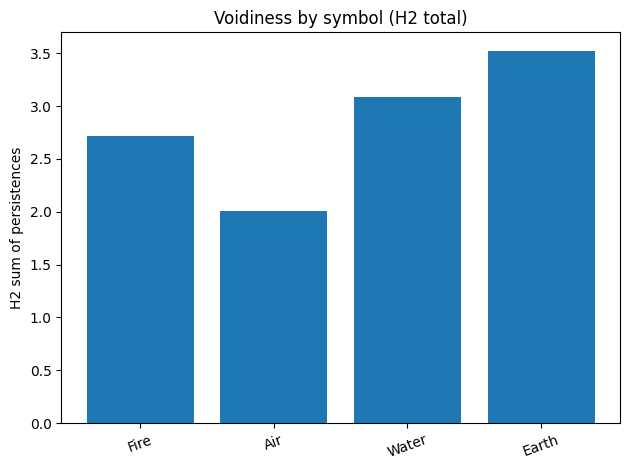

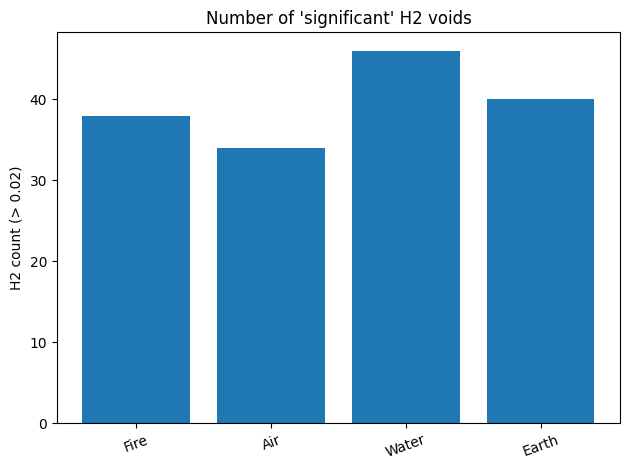

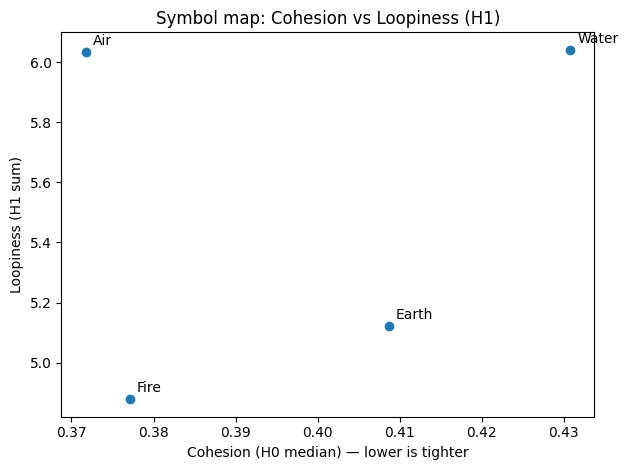

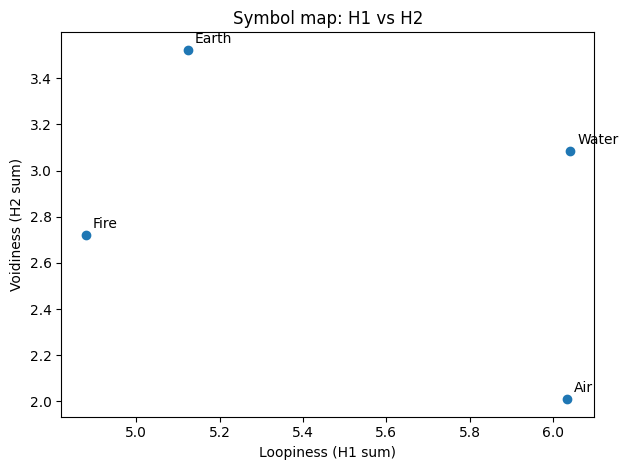

In [22]:
# Per-symbol diagnostics (PCA, H0 barcode, PD, H1 image)
summaries = plot_symbols(embeddings_dict, mode="per-symbol", metric="cosine")

# Cross-symbol comparison suite
_ = plot_symbols(embeddings_dict, mode="compare", metric="cosine", thr=0.02)


In [23]:
# ========================
# Visualizing loops/voids
# ========================
import numpy as np, matplotlib.pyplot as plt
from itertools import combinations

# ---- 2D layout (PCA)
def _layout2d(X):
    X = np.asarray(X, float)
    Xc = X - X.mean(0, keepdims=True)
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
    return Xc @ Vt[:2].T

# ---- distances
def _dists(X, metric="euclidean"):
    if metric=="euclidean":
        diff = X[:,None,:]-X[None,:,:]
        return np.sqrt((diff*diff).sum(-1))
    elif metric=="cosine":
        X = X/(np.linalg.norm(X,axis=1,keepdims=True)+1e-12)
        S = np.clip(X@X.T, -1, 1)
        return 1.0 - S
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'")

# ---- union of balls (great intuition)
def plot_union_of_balls(X, eps, metric="euclidean", title=None):
    Z = _layout2d(X)
    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], s=18, zorder=3)
    for i in range(len(Z)):
        c = plt.Circle((Z[i,0], Z[i,1]), eps, fill=False, alpha=0.5)
        plt.gca().add_patch(c)
    plt.axis('equal'); plt.tight_layout()
    plt.title(title or f"Union of balls (radius ε={eps:.3f})")
    plt.show()

# ---- Rips 2-skeleton at ε (edges + filled triangles)
def _rips_2_skeleton(X, eps, metric="euclidean"):
    D = _dists(X, metric=metric)
    n = len(D)
    edges = [(i,j) for i in range(n) for j in range(i+1,n) if D[i,j] <= eps]
    tris  = []
    for i,j,k in combinations(range(n),3):
        if (D[i,j] <= eps) and (D[i,k] <= eps) and (D[j,k] <= eps):
            tris.append((i,j,k))
    return edges, tris

def plot_rips_skeleton(X, eps, metric="euclidean", title=None, show_tris=True):
    Z = _layout2d(X)
    edges, tris = _rips_2_skeleton(X, eps, metric)
    plt.figure(figsize=(6,5))
    if show_tris:
        for (i,j,k) in tris:
            plt.fill(Z[[i,j,k],0], Z[[i,j,k],1], alpha=0.15, linewidth=0)
    for (i,j) in edges:
        plt.plot(Z[[i,j],0], Z[[i,j],1], linewidth=1, alpha=0.6)
    plt.scatter(Z[:,0], Z[:,1], s=22, zorder=3)
    plt.axis('equal'); plt.tight_layout()
    plt.title(title or f"Vietoris–Rips 2-skeleton at ε={eps:.3f}")
    plt.show()

# ---- Representative H1 loops from ripser cocycles (if available)
def plot_top_H1_representative_loops(X, k=3, metric="euclidean", scale="mid"):
    """
    scale in {'birth','mid','death'} chooses ε for the overlaid skeleton.
    Requires ripser with do_cocycles=True. Falls back to just the skeleton.
    """
    Z = _layout2d(X)
    try:
        from ripser import ripser
        out = ripser(X, maxdim=2, metric=metric, do_cocycles=True)
        H1 = out['dgms'][1]
        cocycles = out['cocycles'][1] if 'cocycles' in out else []
    except Exception:
        H1, cocycles = np.zeros((0,2)), []

    if H1.size == 0:
        # nothing to highlight; show a reasonable skeleton
        eps = np.percentile(_dists(X,metric), 60)
        plot_rips_skeleton(X, eps, metric, title="No H1 bars found — skeleton view")
        return

    # pick top-k by persistence
    pers = np.where(np.isfinite(H1[:,1]), H1[:,1]-H1[:,0], 0.0)
    order = np.argsort(pers)[::-1][:k]
    plt.figure(figsize=(6,5))
    # choose epsilon per selected bar
    for idx in order:
        b,d = float(H1[idx,0]), float(H1[idx,1] if np.isfinite(H1[idx,1]) else H1[idx,0])
        eps = {"birth":b, "mid":(b+d)/2 if d>=b else b, "death":d}.get(scale, (b+d)/2 if d>=b else b)
        edges, tris = _rips_2_skeleton(X, eps, metric)
        # draw light skeleton
        for (i,j) in edges:
            plt.plot(Z[[i,j],0], Z[[i,j],1], linewidth=0.8, alpha=0.2)
        # cocycle (set of edges with coefficients) if we have it
        if len(cocycles) > idx:
            cyc = cocycles[idx]
            # cyc rows: [i, j, coeff]
            for (i,j,coeff) in cyc:
                i, j = int(i), int(j)
                plt.plot(Z[[i,j],0], Z[[i,j],1], linewidth=2.5, alpha=0.95)
        else:
            # fallback: emphasize shortest visible edges (purely visual)
            pass

    plt.scatter(Z[:,0], Z[:,1], s=24, zorder=3)
    plt.axis('equal'); plt.tight_layout()
    plt.title(f"Top {len(order)} representative H1 loops (ε at {scale})")
    plt.show()

# ---- H2: try to draw 2-cocycles if ripser provides them; otherwise show triangles at ε*
def plot_top_H2_representatives(X, k=1, metric="euclidean", scale="mid"):
    """
    Attempts to visualize H2 via 2-cocycles (triangles with coefficients).
    If not available, shows all triangles at ε* for the selected bar(s).
    """
    Z = _layout2d(X)
    try:
        from ripser import ripser
        out = ripser(X, maxdim=2, metric=metric, do_cocycles=True)
        H2 = out['dgms'][2]
        cocycles2 = out['cocycles'][2] if 'cocycles' in out and len(out['cocycles'])>2 else []
    except Exception:
        H2, cocycles2 = np.zeros((0,2)), []

    if H2.size == 0:
        eps = np.percentile(_dists(X,metric), 65)
        plot_rips_skeleton(X, eps, metric, title="No H2 bars found — triangles at ε", show_tris=True)
        return

    pers = np.where(np.isfinite(H2[:,1]), H2[:,1]-H2[:,0], 0.0)
    order = np.argsort(pers)[::-1][:k]

    for idx in order:
        b,d = float(H2[idx,0]), float(H2[idx,1] if np.isfinite(H2[idx,1]) else H2[idx,0])
        eps = {"birth":b, "mid":(b+d)/2 if d>=b else b, "death":d}.get(scale, (b+d)/2 if d>=b else b)
        edges, tris = _rips_2_skeleton(X, eps, metric)

        plt.figure(figsize=(6,5))
        # background skeleton light
        for (i,j) in edges:
            plt.plot(Z[[i,j],0], Z[[i,j],1], linewidth=0.6, alpha=0.25)
        # try to highlight a 2-cocycle (triangular faces)
        shown = False
        if len(cocycles2) > idx and len(cocycles2[idx])>0:
            tri_rows = cocycles2[idx]  # expect rows like [i,j,k,coeff]
            for row in tri_rows:
                i,j,k = map(int, row[:3])
                plt.fill(Z[[i,j,k],0], Z[[i,j,k],1], alpha=0.45)
            shown = True

        if not shown:
            # fallback: show all triangles at ε; visually, “shells” indicate a void
            for (i,j,k) in tris:
                plt.fill(Z[[i,j,k],0], Z[[i,j,k],1], alpha=0.20, linewidth=0)

        plt.scatter(Z[:,0], Z[:,1], s=24, zorder=3)
        plt.axis('equal'); plt.tight_layout()
        plt.title(f"H2 representative (ε at {scale})")
        plt.show()


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


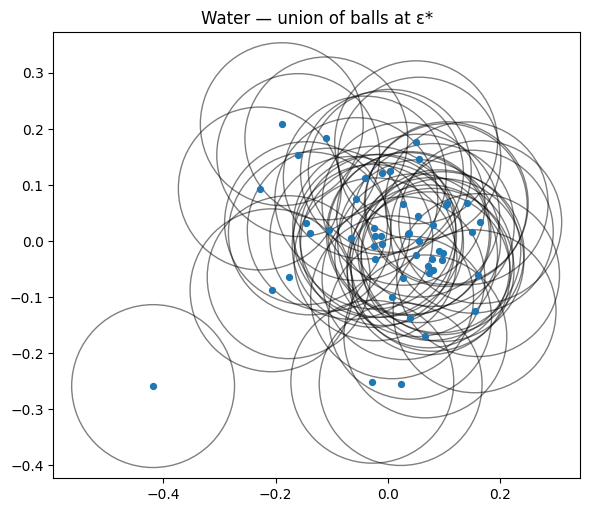

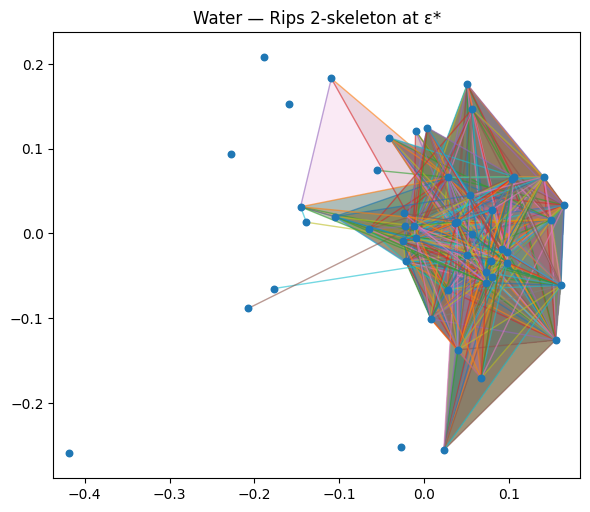

c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


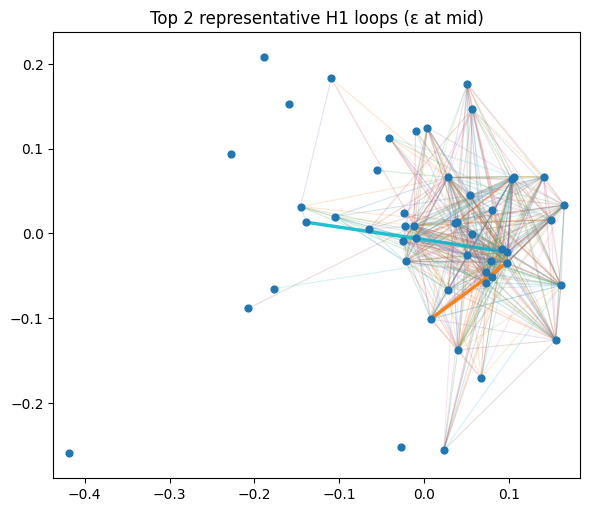

c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


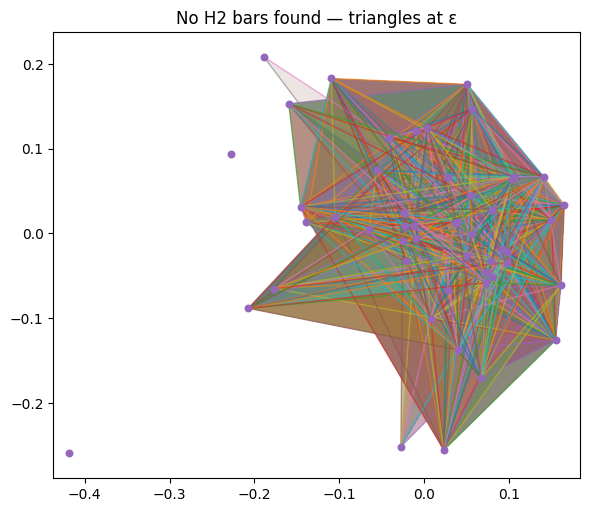

In [29]:
X = embeddings_dict["Earth"]
cosine = 'cosine'
# 1) “Union of balls” intuition at the H1 bar midpoint
from ripser import ripser
dgms = ripser(X, maxdim=2, metric=cosine)["dgms"]
H1 = dgms[1]; idx = np.argmax(np.where(np.isfinite(H1[:,1]), H1[:,1]-H1[:,0], 0))  # most persistent loop
b,d = float(H1[idx,0]), float(H1[idx,1])
eps_star = 0.5*(b+d)

plot_union_of_balls(X, eps_star, metric=cosine, title="Water — union of balls at ε*")
plot_rips_skeleton(X, eps_star, metric=cosine, title="Water — Rips 2-skeleton at ε*")

# 2) Draw the top representative H1 loops (uses cocycles)
plot_top_H1_representative_loops(X, k=2, metric=cosine, scale="mid")

# 3) Try to visualize an H2 representative (triangles)
plot_top_H2_representatives(X, k=1, metric=cosine, scale="mid")


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from typing import Dict, Tuple, List

# ---- Distance helpers (reuse your metric choice)
def _pairwise_dists(X, metric="euclidean"):
    X = np.asarray(X, float)
    if metric == "euclidean":
        diff = X[:, None, :] - X[None, :, :]
        return np.sqrt(np.sum(diff*diff, axis=2))
    elif metric == "cosine":
        X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
        S = np.clip(X @ X.T, -1.0, 1.0)
        return 1.0 - S
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'")

def _sum_finite_persistence(dgm):
    if dgm.size == 0: return 0.0
    finite = np.isfinite(dgm[:,1])
    if not finite.any(): return 0.0
    pers = dgm[finite,1] - dgm[finite,0]
    return float(np.sum(pers))

# ---- Build union + labels for a pair of symbols
def _union_with_labels(A: np.ndarray, B: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    A = np.asarray(A, float); B = np.asarray(B, float)
    X = np.vstack([A, B])
    labels = np.zeros(len(X), dtype=int)
    labels[len(A):] = 1
    # row-normalize (defensive)
    X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    return X, labels

# ---- PH on union and union-without-cross edges (precomputed distances)
def intersymbol_synergy(A: np.ndarray, B: np.ndarray, metric="euclidean"):
    from ripser import ripser
    X, lbl = _union_with_labels(A, B)

    # Union PH (point cloud)
    out = ripser(X, maxdim=2, metric=metric)
    H1u, H2u = out["dgms"][1], out["dgms"][2]
    sumH1_u = _sum_finite_persistence(H1u)
    sumH2_u = _sum_finite_persistence(H2u)

    # Union with cross edges disabled (distance matrix)
    D = _pairwise_dists(X, metric=metric)
    big = 1e9
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if lbl[i] != lbl[j]:
                D[i,j] = D[j,i] = big
    out_nc = ripser(D, maxdim=2, metric="precomputed")
    H1nc, H2nc = out_nc["dgms"][1], out_nc["dgms"][2]
    sumH1_nc = _sum_finite_persistence(H1nc)
    sumH2_nc = _sum_finite_persistence(H2nc)

    return {
        "sumH1_union": sumH1_u,
        "sumH1_no_cross": sumH1_nc,
        "synergy_H1": sumH1_u - sumH1_nc,
        "sumH2_union": sumH2_u,
        "sumH2_no_cross": sumH2_nc,
        "synergy_H2": sumH2_u - sumH2_nc
    }

# ---- Cycle mixing statistics on A∪B
def _cycle_vertex_sets(cocycle, dim=1):
    verts = set()
    if dim == 1:
        for i,j,c in cocycle:
            verts.add(int(i)); verts.add(int(j))
    elif dim == 2:
        for i,j,k,c in cocycle:
            verts.add(int(i)); verts.add(int(j)); verts.add(int(k))
    return verts

def _mixing_entropy(label_counts: List[int]) -> float:
    # Shannon entropy in bits for 2 labels (cap at 1.0 for two-class case)
    total = sum(label_counts)
    if total == 0: return 0.0
    import math
    H = 0.0
    for c in label_counts:
        if c > 0:
            p = c / total
            H -= p * math.log(p, 2)
    return float(H)

def cycle_mixing_stats(A: np.ndarray, B: np.ndarray, metric="euclidean", k1=5, k2=3):
    """
    Returns top-k H1/H2 cycles' (persistence, mixing_entropy, cross_fraction).
    """
    from ripser import ripser
    X, lbl = _union_with_labels(A, B)
    out = ripser(X, maxdim=2, metric=metric, do_cocycles=True)
    H1, H2 = out["dgms"][1], out["dgms"][2]
    coc1 = out.get("cocycles", [[],[],[]])[1] if "cocycles" in out else []
    coc2 = out.get("cocycles", [[],[],[]])[2] if "cocycles" in out else []

    stats_H1 = []
    if H1.size:
        pers = np.where(np.isfinite(H1[:,1]), H1[:,1]-H1[:,0], 0.0)
        order = np.argsort(pers)[::-1][:k1]
        for idx in order:
            p = float(pers[idx])
            cyc = coc1[idx] if idx < len(coc1) else []
            # vertex participation
            verts = _cycle_vertex_sets(cyc, dim=1)
            la = sum(lbl[v]==0 for v in verts)
            lb = sum(lbl[v]==1 for v in verts)
            Hmix = _mixing_entropy([la, lb])
            # cross-edge fraction
            cross_e = 0; total_e = 0
            for i,j,c in cyc:
                i,j = int(i),int(j); total_e += 1
                if lbl[i] != lbl[j]: cross_e += 1
            frac = (cross_e/total_e) if total_e>0 else 0.0
            stats_H1.append({"pers": p, "mix_entropy": Hmix, "cross_frac": frac})

    stats_H2 = []
    if H2.size:
        pers = np.where(np.isfinite(H2[:,1]), H2[:,1]-H2[:,0], 0.0)
        order = np.argsort(pers)[::-1][:k2]
        for idx in order:
            p = float(pers[idx])
            cyc = coc2[idx] if idx < len(coc2) else []
            verts = _cycle_vertex_sets(cyc, dim=2)
            la = sum(lbl[v]==0 for v in verts)
            lb = sum(lbl[v]==1 for v in verts)
            Hmix = _mixing_entropy([la, lb])
            # triangles spanning both labels
            cross_t = 0; total_t = 0
            for row in cyc:
                i,j,k = map(int, row[:3]); total_t += 1
                labs = {lbl[i], lbl[j], lbl[k]}
                if len(labs) >= 2: cross_t += 1
            frac = (cross_t/total_t) if total_t>0 else 0.0
            stats_H2.append({"pers": p, "mix_entropy": Hmix, "cross_frac": frac})

    return stats_H1, stats_H2

# ---- Cross-weight vineyard: inflate A↔B edges by alpha
def intersymbol_vineyard(A: np.ndarray, B: np.ndarray, metric="euclidean", alphas=(0.0, 1.0, 2.0, 4.0)):
    from ripser import ripser
    X, lbl = _union_with_labels(A, B)
    D0 = _pairwise_dists(X, metric=metric)
    sums_H1, sums_H2 = [], []
    for a in alphas:
        D = D0.copy()
        if a != 0.0 and a != 1.0:
            for i in range(len(X)):
                for j in range(i+1, len(X)):
                    if lbl[i] != lbl[j]:
                        D[i,j] = D[j,i] = a * D[i,j]
        out = ripser(D, maxdim=2, metric="precomputed")
        H1, H2 = out["dgms"][1], out["dgms"][2]
        sums_H1.append(_sum_finite_persistence(H1))
        sums_H2.append(_sum_finite_persistence(H2))
    return np.array(alphas), np.array(sums_H1), np.array(sums_H2)

# ---- Convenience wrapper over all unordered pairs in your dict
def quantify_inter_symbol_PH(embeddings_dict: Dict[str, np.ndarray], metric="euclidean"):
    import itertools, pandas as pd
    rows = []
    keys = list(embeddings_dict.keys())
    for (sa, sb) in itertools.combinations(keys, 2):
        A = embeddings_dict[sa]; B = embeddings_dict[sb]
        syn = intersymbol_synergy(A, B, metric=metric)
        rows.append({"pair": f"{sa}–{sb}", **syn})
    df = pd.DataFrame(rows).sort_values("synergy_H1", ascending=False)
    return df

# ---- Simple plots (matplotlib, one figure each)
def plot_pair_vineyard(A, B, title, metric="euclidean", alphas=(0.0,1.0,2.0,4.0)):
    a, s1, s2 = intersymbol_vineyard(A, B, metric=metric, alphas=alphas)
    plt.figure(); plt.plot(a, s1, marker="o"); plt.xlabel("Cross-weight α"); plt.ylabel("Σ H1 persistence")
    plt.title(f"{title} — H1 vineyard"); plt.tight_layout(); plt.show()
    plt.figure(); plt.plot(a, s2, marker="o"); plt.xlabel("Cross-weight α"); plt.ylabel("Σ H2 persistence")
    plt.title(f"{title} — H2 vineyard"); plt.tight_layout(); plt.show()

def plot_cycle_mixing_scatter(A, B, title, metric="euclidean"):
    H1c, H2c = cycle_mixing_stats(A, B, metric=metric, k1=6, k2=4)
    if H1c:
        x = [c["mix_entropy"] for c in H1c]; y = [c["pers"] for c in H1c]
        plt.figure(); plt.scatter(x, y)
        plt.xlabel("H1 mixing entropy (bits)"); plt.ylabel("H1 persistence")
        plt.title(f"{title} — cycle mixing (H1)"); plt.tight_layout(); plt.show()
    if H2c:
        x = [c["mix_entropy"] for c in H2c]; y = [c["pers"] for c in H2c]
        plt.figure(); plt.scatter(x, y)
        plt.xlabel("H2 mixing entropy (bits)"); plt.ylabel("H2 persistence")
        plt.title(f"{title} — cycle mixing (H2)"); plt.tight_layout(); plt.show()


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to

          pair  sumH1_union  sumH1_no_cross  synergy_H1  sumH2_union  \
4    Air–Earth     0.155185        0.092962    0.062223     0.006160   
1   Fire–Water     0.165126        0.126854    0.038272     0.002237   
0     Fire–Air     0.206238        0.168881    0.037357     0.009397   
5  Water–Earth     0.073451        0.050935    0.022516     0.000000   
3    Air–Water     0.135504        0.120195    0.015310     0.001676   
2   Fire–Earth     0.093501        0.099622   -0.006120     0.006105   

   sumH2_no_cross  synergy_H2  
4        0.005183    0.000977  
1        0.010884   -0.008647  
0        0.016067   -0.006670  
5        0.000000    0.000000  
3        0.005183   -0.003507  
2        0.010884   -0.004779  


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


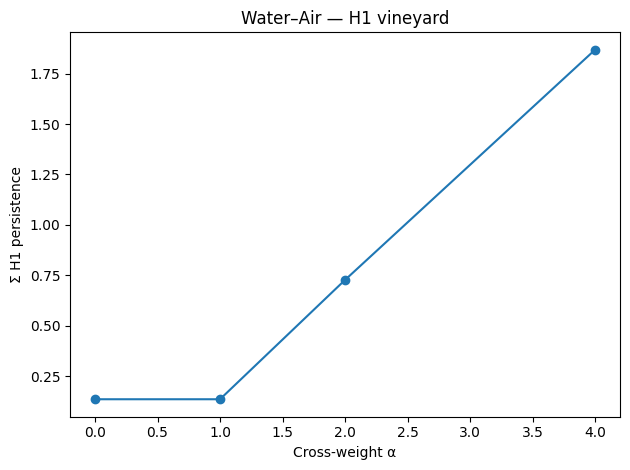

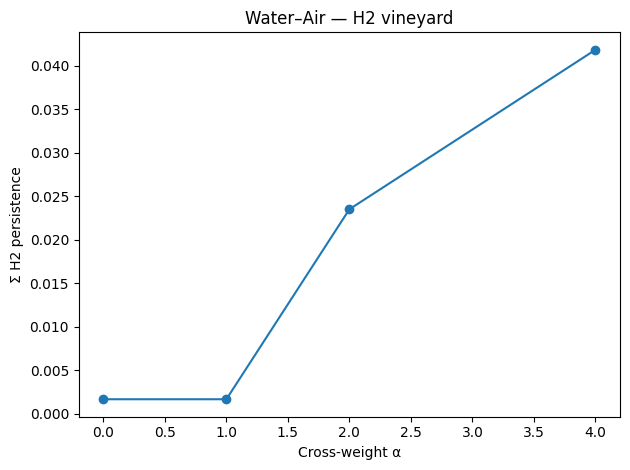

c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


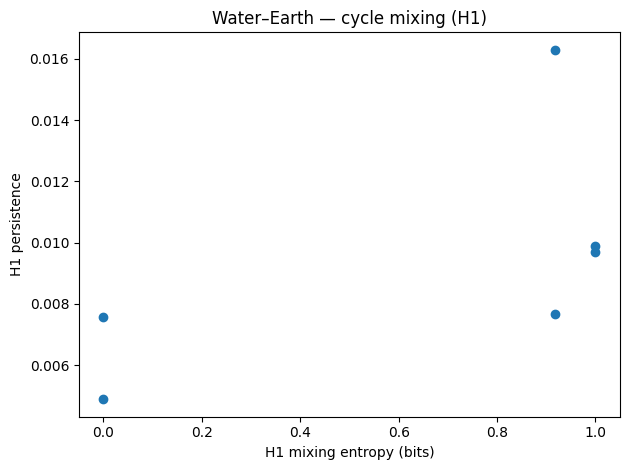

In [31]:
# 1) Table of inter-symbol synergy (all pairs)
df_pairs = quantify_inter_symbol_PH(embeddings_dict, metric="euclidean")
print(df_pairs)
# Columns: pair, sumH1_union, sumH1_no_cross, synergy_H1, sumH2_union, sumH2_no_cross, synergy_H2

# 2) “Vineyard” for one pair (does loopiness/voidiness rely on A↔B bridges?)
plot_pair_vineyard(embeddings_dict["Water"], embeddings_dict["Air"], "Water–Air")

# 3) Which shared cycles are truly mixed? (entropy vs persistence)
plot_cycle_mixing_scatter(embeddings_dict["Water"], embeddings_dict["Earth"], "Water–Earth")


In [32]:
import numpy as np
from typing import List, Dict, Any

def _ph_with_cocycles(X, metric="euclidean"):
    from ripser import ripser
    return ripser(X, maxdim=2, metric=metric, do_cocycles=True)

def _finite_persistence(dgm):
    if dgm.size == 0: 
        return np.zeros((0,)), np.arange(0)
    pers = np.where(np.isfinite(dgm[:,1]), dgm[:,1]-dgm[:,0], 0.0)
    return pers, np.argsort(pers)[::-1]

def _h1_vertices_from_cocycle(cocycle):
    V=set()
    for i,j,c in cocycle: V.update([int(i), int(j)])
    return sorted(V)

def _h2_vertices_from_cocycle(cocycle):
    V=set()
    for row in cocycle:
        i,j,k = map(int, row[:3]); V.update([i,j,k])
    return sorted(V)

def extract_symbol_cycles(symbol: str,
                          X: np.ndarray,
                          words: List[str],
                          metric: str = "euclidean",
                          top_k1: int = 5,
                          top_k2: int = 3) -> Dict[str, List[Dict[str, Any]]]:
    """
    Returns dict with lists of top H1 and H2 cycles; each item has:
      birth, death, persistence, vertex_ids, word_list
    """
    out = _ph_with_cocycles(X, metric=metric)
    H1, H2 = out["dgms"][1], out["dgms"][2]
    coc1 = out.get("cocycles",[[],[],[]])[1] if "cocycles" in out else []
    coc2 = out.get("cocycles",[[],[],[]])[2] if "cocycles" in out else []

    res = {"H1": [], "H2": []}

    pers1, order1 = _finite_persistence(H1)
    for idx in order1[:top_k1]:
        cyc = coc1[idx] if idx < len(coc1) else []
        V = _h1_vertices_from_cocycle(cyc)
        res["H1"].append({
            "birth": float(H1[idx,0]), "death": float(H1[idx,1]),
            "persistence": float(pers1[idx]),
            "vertex_ids": V,
            "words": [words[i] for i in V]
        })

    pers2, order2 = _finite_persistence(H2)
    for idx in order2[:top_k2]:
        cyc = coc2[idx] if idx < len(coc2) else []
        V = _h2_vertices_from_cocycle(cyc)
        res["H2"].append({
            "birth": float(H2[idx,0]), "death": float(H2[idx,1]),
            "persistence": float(pers2[idx]),
            "vertex_ids": V,
            "words": [words[i] for i in V]
        })
    return res


In [33]:
report = extract_symbol_cycles("Water", embeddings_dict["Water"], symbols_to_words["Water"])
for cyc in report["H1"]:
    print("H1 loop:", cyc["persistence"], cyc["words"])
for cyc in report["H2"]:
    print("H2 void:", cyc["persistence"], cyc["words"])


H1 loop: 0.013932883739471436 ['dew', 'change', 'intuitive']
H1 loop: 0.010006994009017944 ['storm', 'cleansing', 'dream']
H1 loop: 0.007578849792480469 ['current', 'birth']
H1 loop: 0.0033722519874572754 ['ice', 'intuitive']
H1 loop: 0.0033611059188842773 ['tsunami', 'mirror']


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


In [34]:
from typing import Tuple

def _union_X_labels_words(A, wordsA, B, wordsB):
    A = np.asarray(A, float); B = np.asarray(B, float)
    X = np.vstack([A, B])
    labels = np.array([0]*len(A) + [1]*len(B), int)
    words  = list(wordsA) + list(wordsB)
    X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    return X, labels, words

def _mix_label_of_vertices(V, labels):
    labs = labels[V]
    if np.all(labs==0): return "pure_A"
    if np.all(labs==1): return "pure_B"
    return "mixed"

def extract_pair_cycles(
    A: np.ndarray, wordsA: List[str],
    B: np.ndarray, wordsB: List[str],
    metric="euclidean", top_k1=6, top_k2=4
):
    X, lbl, words = _union_X_labels_words(A, wordsA, B, wordsB)
    out = _ph_with_cocycles(X, metric=metric)
    H1, H2 = out["dgms"][1], out["dgms"][2]
    coc1 = out.get("cocycles",[[],[],[]])[1] if "cocycles" in out else []
    coc2 = out.get("cocycles",[[],[],[]])[2] if "cocycles" in out else []

    res = {"H1": [], "H2": []}
    pers1, order1 = _finite_persistence(H1)
    for idx in order1[:top_k1]:
        cyc = coc1[idx] if idx < len(coc1) else []
        V = _h1_vertices_from_cocycle(cyc)
        tag = _mix_label_of_vertices(np.array(V, int), lbl)
        res["H1"].append({
            "birth": float(H1[idx,0]), "death": float(H1[idx,1]),
            "persistence": float(pers1[idx]),
            "mix": tag,
            "vertex_ids": V,
            "words": [words[i] + (" [A]" if lbl[i]==0 else " [B]") for i in V]
        })

    pers2, order2 = _finite_persistence(H2)
    for idx in order2[:top_k2]:
        cyc = coc2[idx] if idx < len(coc2) else []
        V = _h2_vertices_from_cocycle(cyc)
        tag = _mix_label_of_vertices(np.array(V, int), lbl)
        res["H2"].append({
            "birth": float(H2[idx,0]), "death": float(H2[idx,1]),
            "persistence": float(pers2[idx]),
            "mix": tag,
            "vertex_ids": V,
            "words": [words[i] + (" [A]" if lbl[i]==0 else " [B]") for i in V]
        })
    return res


In [35]:
pair = extract_pair_cycles(
    embeddings_dict["Water"], symbols_to_words["Water"],
    embeddings_dict["Air"],   symbols_to_words["Air"],
)
for cyc in pair["H1"]:
    print(cyc["mix"], "H1", cyc["persistence"], cyc["words"])
for cyc in pair["H2"]:
    print(cyc["mix"], "H2", cyc["persistence"], cyc["words"])


mixed H1 0.016810297966003418 ['lake [A]', 'mind [B]']
mixed H1 0.013073772192001343 ['erosion [A]', 'breath [B]']
pure_B H1 0.012821793556213379 ['draft [B]', 'flight [B]', 'inspiration [B]', 'space [B]', 'howl [B]']
pure_B H1 0.011956244707107544 ['breath [B]', 'thought [B]']
mixed H1 0.009239822626113892 ['intuitive [A]', 'movement [B]']
mixed H1 0.009222447872161865 ['intuitive [A]', 'cyclone [B]', 'awakening [B]']
mixed H2 0.0011138916015625 ['erosion [A]', 'breath [B]', 'stormy [B]', 'north [B]']
mixed H2 0.0003630220890045166 ['life [A]', 'intuitive [A]', 'flight [B]', 'hurricane [B]', 'clarity [B]', 'communication [B]']
mixed H2 0.0001990199089050293 ['foam [A]', 'change [A]', 'clarity [B]', 'mind [B]']


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


## No Hairball

import matplotlib.pyplot as plt

def _pca2d(X):
    Xc = X - X.mean(0, keepdims=True)
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
    return Xc @ Vt[:2].T

def plot_labeled_cycle(X, words, vertex_ids, title="Cycle"):
    Z = _pca2d(X)
    V = np.array(vertex_ids, int)
    plt.figure(figsize=(6,5))
    # light background points
    plt.scatter(Z[:,0], Z[:,1], s=14, alpha=0.2)
    # highlight cycle vertices
    plt.scatter(Z[V,0], Z[V,1], s=32)
    # label them
    for i in V:
        plt.annotate(words[i], (Z[i,0], Z[i,1]), textcoords="offset points", xytext=(5,5))
    plt.axis("equal"); plt.title(title); plt.tight_layout(); plt.show()


In [36]:
import matplotlib.pyplot as plt

def _pca2d(X):
    Xc = X - X.mean(0, keepdims=True)
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
    return Xc @ Vt[:2].T

def plot_labeled_cycle(X, words, vertex_ids, title="Cycle"):
    Z = _pca2d(X)
    V = np.array(vertex_ids, int)
    plt.figure(figsize=(6,5))
    # light background points
    plt.scatter(Z[:,0], Z[:,1], s=14, alpha=0.2)
    # highlight cycle vertices
    plt.scatter(Z[V,0], Z[V,1], s=32)
    # label them
    for i in V:
        plt.annotate(words[i], (Z[i,0], Z[i,1]), textcoords="offset points", xytext=(5,5))
    plt.axis("equal"); plt.title(title); plt.tight_layout(); plt.show()


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


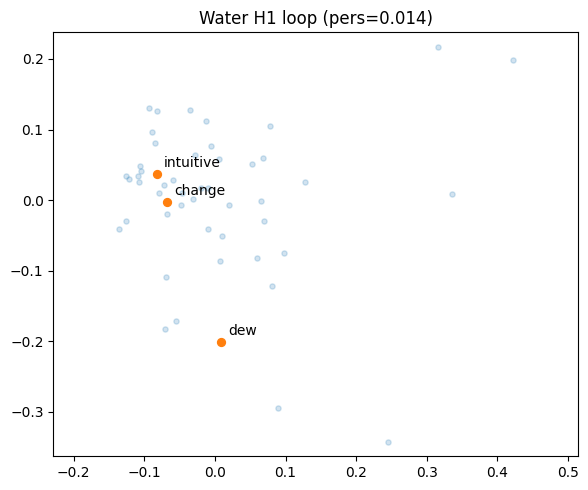

In [37]:
rep = extract_symbol_cycles("Water", embeddings_dict["Water"], symbols_to_words["Water"])
if rep["H1"]:
    cyc0 = rep["H1"][0]
    plot_labeled_cycle(embeddings_dict["Water"], symbols_to_words["Water"],
                       cyc0["vertex_ids"], title=f"Water H1 loop (pers={cyc0['persistence']:.3f})")


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


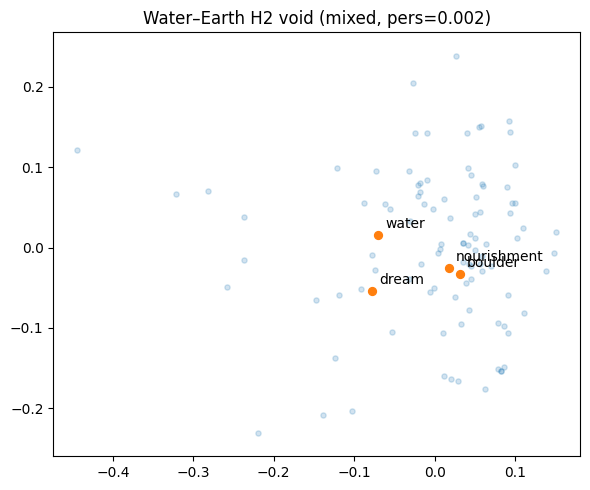

In [40]:
sym1 = 'Fire'
sym2 = 'Water'

pair = extract_pair_cycles(embeddings_dict[sym1], symbols_to_words[sym1],
                           embeddings_dict[sym2], symbols_to_words[sym2])
if pair["H2"]:
    cyc = pair["H2"][0]
    # Make a unified X/words for plotting
    XU = np.vstack([embeddings_dict[sym1], embeddings_dict[sym2]])
    wordsU = symbols_to_words["Water"] + symbols_to_words["Earth"]
    plot_labeled_cycle(XU, wordsU, cyc["vertex_ids"],
                       title=f"Water–Earth H2 void ({cyc['mix']}, pers={cyc['persistence']:.3f})")


In [41]:
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

def _row_norm(X): return X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)

def pca(X, k):
    X = np.asarray(X, float)
    Xc = X - X.mean(0, keepdims=True)
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
    # scores = X in principal-component coords; loadings = Vt.T
    Z = Xc @ Vt[:k].T
    return Z, Vt[:k].T, Xc

def varimax(Phi, gamma=1.0, q=50, tol=1e-6):
    # Phi: (features, k) loadings matrix
    p,k = Phi.shape
    R = np.eye(k)
    d = 0
    for i in range(q):
        Λ = Phi @ R
        u, s, vh = np.linalg.svd(Phi.T @ (Λ**3 - (gamma/p) * Λ @ np.diag(np.sum(Λ**2, axis=0))))
        R = u @ vh
        if np.abs(s.sum() - d) < tol: break
        d = s.sum()
    return Phi @ R, R  # rotated loadings, rotation


In [46]:
def concept_direction_from_wordsets(all_words, all_vectors, pos_words, neg_words):
    # average the embeddings of selected words to create a direction
    name_to_vec = {w: v for w,v in zip(all_words, all_vectors)}
    P = np.stack([name_to_vec[w] for w in pos_words if w in name_to_vec])
    N = np.stack([name_to_vec[w] for w in neg_words if w in name_to_vec])
    d = _row_norm(P.mean(0, keepdims=True)) - _row_norm(N.mean(0, keepdims=True))
    d = d[0] / (np.linalg.norm(d) + 1e-12)
    return d

def concept_cube_scatter(embeddings_dict, symbols_to_words,
                         axis_defs,  # list of 3 tuples: (axis_name, pos_words, neg_words)
                         title="Concept cube (3D)"):
    # build a global list of (word, vector) across symbols
    all_words, all_vecs = [], []
    for s, X in embeddings_dict.items():
        all_words += symbols_to_words[s]
        all_vecs  += list(X)
    all_vecs = np.vstack(all_vecs)
    all_vecs = _row_norm(all_vecs)

    # axes
    dirs = []
    for (name, pos, neg) in axis_defs:
        d = concept_direction_from_wordsets(all_words, all_vecs, pos, neg)
        dirs.append(d)
    D = np.stack(dirs, 1)    # (d,3)

    # project every word
    scores = all_vecs @ D    # (n,3)

    # 3D scatter
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(scores[:,0], scores[:,1], scores[:,2], s=10)
    # label a few extremes on each axis
    for a in range(3):
        idx_hi = np.argmax(scores[:,a]); idx_lo = np.argmin(scores[:,a])
        ax.text(scores[idx_hi,0], scores[idx_hi,1], scores[idx_hi,2], all_words[idx_hi], fontsize=8)
        ax.text(scores[idx_lo,0], scores[idx_lo,1], scores[idx_lo,2], all_words[idx_lo], fontsize=8)
    ax.set_xlabel(axis_defs[0][0]); ax.set_ylabel(axis_defs[1][0]); ax.set_zlabel(axis_defs[2][0])
    ax.set_title(title); plt.tight_layout(); plt.show()


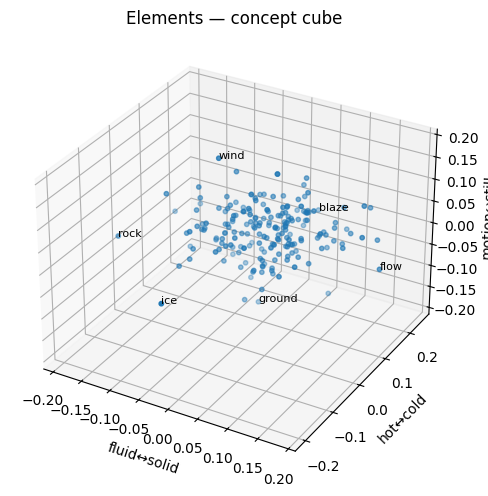

In [47]:
axes = [
  ("fluid↔solid",  ["water","river","flow","wave"], ["rock","stone","mountain","soil"]),
  ("hot↔cold",     ["fire","blaze","flame"],        ["ice","snow","frost"]),
  ("motion↔still", ["wind","storm","flight"],       ["root","ground","valley"])
]
concept_cube_scatter(embeddings_dict, symbols_to_words, axes, title="Elements — concept cube")


In [50]:
import numpy as np, matplotlib.pyplot as plt
from typing import Dict, List, Tuple

# --------- simple PH metrics (reuse your earlier versions if you have them) ---------
def _row_norm(X): return X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)

def _pairwise_dists(X, metric="euclidean"):
    X = np.asarray(X, float)
    if metric == "euclidean":
        diff = X[:,None,:] - X[None,:,:]
        return np.sqrt(np.sum(diff*diff, axis=2))
    elif metric == "cosine":
        X = _row_norm(X)
        S = np.clip(X@X.T, -1, 1)
        return 1.0 - S
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'")

def compute_persistent_homology(X, metric="euclidean", maxdim=2):
    # try ripser; fallback omitted here for brevity
    from ripser import ripser
    out = ripser(X, maxdim=maxdim, metric=metric)
    dgms = out["dgms"]
    return {0: dgms[0], 1: dgms[1], 2: dgms[2] if maxdim>=2 else np.zeros((0,2))}

def _sum_finite(dgm):
    if dgm.size==0: return 0.0
    m = np.isfinite(dgm[:,1])
    if not m.any(): return 0.0
    return float(np.sum(dgm[m,1]-dgm[m,0]))

def ph_summary(X, metric="euclidean"):
    dgms = compute_persistent_homology(_row_norm(X), metric=metric, maxdim=2)
    H0, H1, H2 = dgms[0], dgms[1], dgms[2]
    # cohesion/outlierness from finite H0 bars
    if H0.size and np.isfinite(H0[:,1]).any():
        pers0 = H0[np.isfinite(H0[:,1])]
        p0 = pers0[:,1]-pers0[:,0]
        h0_median, h0_max = float(np.median(p0)), float(np.max(p0))
    else:
        h0_median, h0_max = 0.0, 0.0
    return {
        "H0_median": h0_median,
        "H0_max":    h0_max,
        "H1_sum":    _sum_finite(H1),
        "H2_sum":    _sum_finite(H2),
    }

# --------- PCA + varimax rotated basis (global across all symbols) ---------
def pca(X, k):
    Xc = X - X.mean(0, keepdims=True)
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)  # Vt: (d,d), columns=PCs
    loadings = Vt[:k].T   # (d,k)
    return Xc, loadings, X.mean(0)

def varimax(Phi, gamma=1.0, q=50, tol=1e-6):
    p,k = Phi.shape
    R = np.eye(k); d = 0
    for _ in range(q):
        Λ = Phi @ R
        u,s,vh = np.linalg.svd(Phi.T @ (Λ**3 - (gamma/p)*Λ @ np.diag(np.sum(Λ**2,axis=0))))
        R = u @ vh
        if abs(s.sum()-d) < tol: break
        d = s.sum()
    return Phi @ R, R

def build_global_rotated_basis(embeddings_dict: Dict[str, np.ndarray], n_components=20):
    # concatenate everything to learn a single basis
    mats = [np.asarray(X, float) for X in embeddings_dict.values()]
    Xall = _row_norm(np.vstack(mats))
    Xc, L, mu = pca(Xall, n_components)     # loadings (d,k)
    Lr, R = varimax(L)                      # rotated loadings (d,k)
    return mu, Lr   # mean and rotated basis vectors (columns)

def project_scores(X, mu, Lr):
    # X: (n,d); Lr: (d,k); returns rotated scores Zr (n,k)
    Xc = X - mu
    return Xc @ Lr

def reconstruct_from_scores(Zr, mu, Lr):
    # Zr: (n,k); returns X' in original space
    return mu + Zr @ Lr.T

# --------- component amputation + measurement ---------
def amputate_components_and_measure(
    embeddings_dict: Dict[str, np.ndarray],
    mu, Lr,
    comps: List[int] = None,       # which rotated components to scan; None -> all
    metric: str = "euclidean"
):
    """
    Returns dict: symbol -> DataFrame with baseline + Δ metrics for each component ablation.
    Δ = baseline - after_ablation (positive means that component supports the metric).
    """
    import pandas as pd
    k = Lr.shape[1]
    if comps is None: comps = list(range(k))
    results = {}

    # baselines per symbol
    baselines = {s: ph_summary(_row_norm(X), metric=metric) for s,X in embeddings_dict.items()}

    for s, X in embeddings_dict.items():
        X = _row_norm(np.asarray(X, float))
        Z = project_scores(X, mu, Lr)              # (n,k)
        base = baselines[s]
        rows = []
        for c in comps:
            Zcut = Z.copy()
            Zcut[:, c] = 0.0                       # amputate rotated component c
            Xcut = _row_norm(reconstruct_from_scores(Zcut, mu, Lr))
            m = ph_summary(Xcut, metric=metric)
            rows.append({
                "component": c+1,
                "ΔH0_median": base["H0_median"] - m["H0_median"],
                "ΔH0_max":    base["H0_max"]    - m["H0_max"],
                "ΔH1_sum":    base["H1_sum"]    - m["H1_sum"],
                "ΔH2_sum":    base["H2_sum"]    - m["H2_sum"],
            })
        results[s] = pd.DataFrame(rows)
    return results

def plot_component_importance(df, metric_name="ΔH1_sum", title_prefix="Component importance"):
    plt.figure(figsize=(7,4))
    plt.bar(df["component"], df[metric_name])
    plt.xlabel("Rotated component index")
    plt.ylabel(metric_name)
    plt.title(f"{title_prefix} — {metric_name}")
    plt.tight_layout(); plt.show()

# --------- between-symbol: which components drive SHARED topology? ---------
def intersymbol_synergy(A, B, metric="euclidean"):
    from ripser import ripser
    X = np.vstack([_row_norm(A), _row_norm(B)])
    out_u = ripser(X, maxdim=2, metric=metric)
    H1u, H2u = out_u["dgms"][1], out_u["dgms"][2]
    sumH1_u = _sum_finite(H1u); sumH2_u = _sum_finite(H2u)

    # remove cross edges
    D = _pairwise_dists(X, metric=metric)
    nA = len(A)
    big = 1e9
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if (i<nA) != (j<nA):
                D[i,j]=D[j,i]=big
    out_nc = ripser(D, maxdim=2, metric="precomputed")
    H1nc, H2nc = out_nc["dgms"][1], out_nc["dgms"][2]
    sumH1_nc = _sum_finite(H1nc); sumH2_nc = _sum_finite(H2nc)
    return (sumH1_u - sumH1_nc, sumH2_u - sumH2_nc)  # (synergy_H1, synergy_H2)

def synergy_component_scan(A, B, mu, Lr, metric="euclidean", comps=None):
    """
    Amputate one rotated component from BOTH A and B, recompute synergy.
    Returns: DataFrame with Δsynergy (baseline - after).
    """
    import pandas as pd
    base_H1, base_H2 = intersymbol_synergy(A, B, metric=metric)
    k = Lr.shape[1]
    if comps is None: comps = list(range(k))

    def amputate(X, c):
        Z = project_scores(_row_norm(X), mu, Lr)
        Z[:, c] = 0.0
        return _row_norm(reconstruct_from_scores(Z, mu, Lr))

    rows = []
    for c in comps:
        A2 = amputate(A, c); B2 = amputate(B, c)
        h1, h2 = intersymbol_synergy(A2, B2, metric=metric)
        rows.append({
            "component": c+1,
            "Δsynergy_H1": base_H1 - h1,
            "Δsynergy_H2": base_H2 - h2
        })
    return pd.DataFrame(rows)

# --------- optional: raw-dimension/block amputation instead of rotated comps ---------
def block_groups(d, block=32):
    return [list(range(i, min(i+block, d))) for i in range(0, d, block)]

def amputate_raw_blocks_and_measure(X, groups: List[List[int]], metric="euclidean"):
    """
    Returns list of dicts with Δ metrics for each raw-dimension group.
    """
    base = ph_summary(_row_norm(X), metric=metric)
    rows = []
    for gi, idxs in enumerate(groups, 1):
        X2 = X.copy()
        X2[:, idxs] = 0.0
        m = ph_summary(_row_norm(X2), metric=metric)
        rows.append({
            "group": gi, "dims": (idxs[0]+1, idxs[-1]+1),
            "ΔH0_median": base["H0_median"] - m["H0_median"],
            "ΔH0_max":    base["H0_max"]    - m["H0_max"],
            "ΔH1_sum":    base["H1_sum"]    - m["H1_sum"],
            "ΔH2_sum":    base["H2_sum"]    - m["H2_sum"],
        })
    import pandas as pd
    return pd.DataFrame(rows)


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\

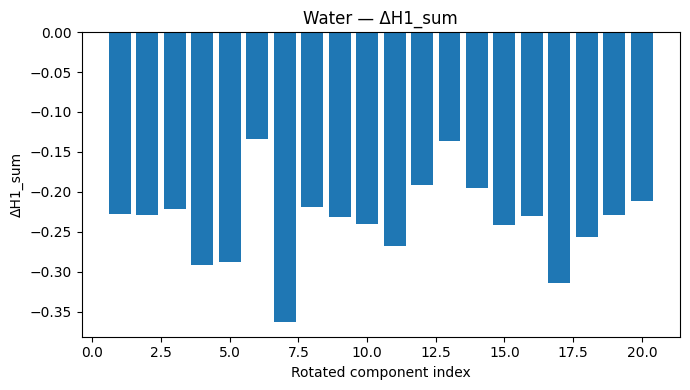

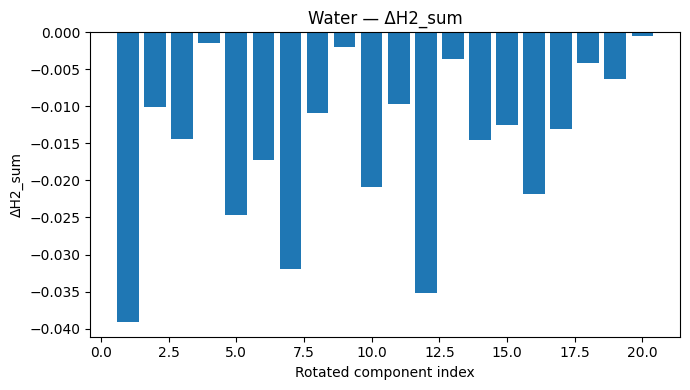

c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to

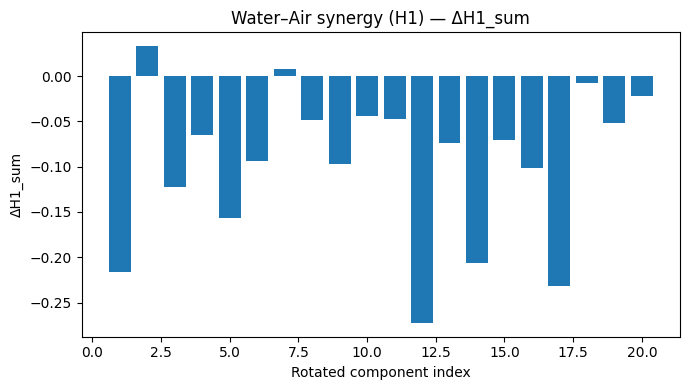

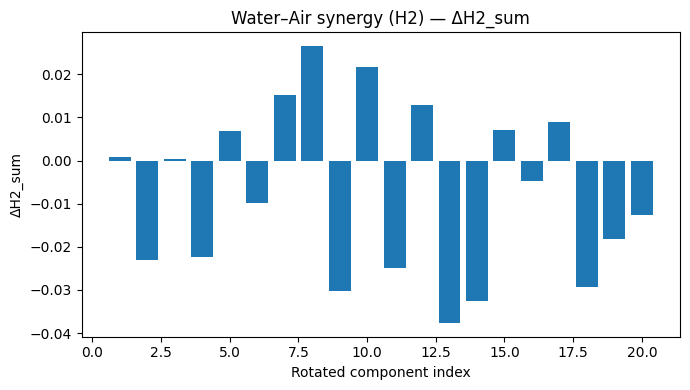

c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\

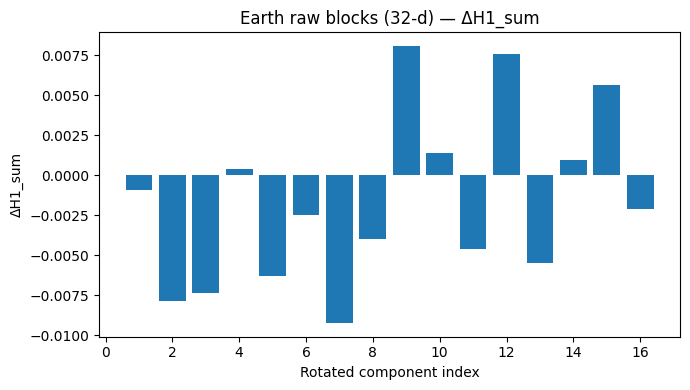

In [51]:
# 1) Build a global rotated basis from ALL symbols (e.g., top-20 components)
mu, Lr = build_global_rotated_basis(embeddings_dict, n_components=20)

# 2) Which components drive topology *within* each symbol?
results = amputate_components_and_measure(embeddings_dict, mu, Lr, metric="euclidean")
# Example: visualize for "Water"
plot_component_importance(results["Water"], "ΔH1_sum", title_prefix="Water")
plot_component_importance(results["Water"], "ΔH2_sum", title_prefix="Water")

# 3) Which components drive **shared** topology between two symbols?
df_syn = synergy_component_scan(embeddings_dict["Water"], embeddings_dict["Air"], mu, Lr)
plot_component_importance(df_syn.rename(columns={"Δsynergy_H1":"ΔH1_sum"}),
                          "ΔH1_sum", title_prefix="Water–Air synergy (H1)")
plot_component_importance(df_syn.rename(columns={"Δsynergy_H2":"ΔH2_sum"}),
                          "ΔH2_sum", title_prefix="Water–Air synergy (H2)")

# 4) (Optional) Old-school raw-dimension or block amputations
X = embeddings_dict["Earth"]
df_blocks = amputate_raw_blocks_and_measure(X, block_groups(X.shape[1], block=32))
plot_component_importance(df_blocks.rename(columns={"group":"component"}),
                          "ΔH1_sum", title_prefix="Earth raw blocks (32-d)")


In [55]:
import numpy as np, pandas as pd

def intrinsic_topology_scores(embeddings_dict, metric="euclidean"):
    from ripser import ripser
    def sum_finite(dgm):
        if dgm.size==0: return 0.0
        m = np.isfinite(dgm[:,1])
        return float(np.sum(dgm[m,1]-dgm[m,0])) if m.any() else 0.0

    rows = []
    for s, X in embeddings_dict.items():
        out = ripser(X, maxdim=2, metric=metric)
        H0, H1, H2 = out["dgms"][0], out["dgms"][1], out["dgms"][2]
        # cohesion from H0
        if H0.size and np.isfinite(H0[:,1]).any():
            p0 = H0[np.isfinite(H0[:,1])]
            p0 = p0[:,1]-p0[:,0]
            h0_median = float(np.median(p0))
        else:
            h0_median = 0.0
        rows.append({
            "symbol": s,
            "H0_cohesion": h0_median,      # lower = tighter
            "H1_sum":      sum_finite(H1), # loopiness
            "H2_sum":      sum_finite(H2)  # voidiness
        })
    df = pd.DataFrame(rows)
    # optional composite (z-scored): more loops/voids, tighter cluster (invert H0)
    for col in ["H1_sum","H2_sum","H0_cohesion"]:
        df[col+"_z"] = (df[col]-df[col].mean())/(df[col].std()+1e-12)
    df["TopoScore"] = df["H1_sum_z"] + df["H2_sum_z"] - df["H0_cohesion_z"]
    return df.sort_values("TopoScore", ascending=False)


import itertools, pandas as pd, numpy as np

def pair_synergy(A, B, metric="euclidean"):
    from ripser import ripser
    import numpy as np
    XA = A/ (np.linalg.norm(A,axis=1,keepdims=True)+1e-12)
    XB = B/ (np.linalg.norm(B,axis=1,keepdims=True)+1e-12)
    X  = np.vstack([XA, XB])
    # union PH
    out = ripser(X, maxdim=2, metric=metric)
    H1u, H2u = out["dgms"][1], out["dgms"][2]
    def sumf(dgm):
        if dgm.size==0: return 0.0
        m = np.isfinite(dgm[:,1])
        return float(np.sum(dgm[m,1]-dgm[m,0])) if m.any() else 0.0
    s1u, s2u = sumf(H1u), sumf(H2u)
    # remove cross edges
    D = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(-1))
    nA = len(XA); big = 1e9
    for i in range(len(X)):
        for j in range(i+1,len(X)):
            if (i<nA) != (j<nA): D[i,j]=D[j,i]=big
    out2 = ripser(D, maxdim=2, metric="precomputed")
    s1nc, s2nc = sumf(out2["dgms"][1]), sumf(out2["dgms"][2])
    return s1u - s1nc, s2u - s2nc  # synergy_H1, synergy_H2

def synergy_centrality(embeddings_dict, metric="euclidean"):
    keys = list(embeddings_dict.keys())
    S = {k: {"synergy_H1":0.0,"synergy_H2":0.0} for k in keys}
    for a,b in itertools.combinations(keys,2):
        h1,h2 = pair_synergy(embeddings_dict[a], embeddings_dict[b], metric=metric)
        S[a]["synergy_H1"] += h1; S[b]["synergy_H1"] += h1
        S[a]["synergy_H2"] += h2; S[b]["synergy_H2"] += h2
    df = pd.DataFrame([{"symbol":k, **v} for k,v in S.items()])
    # composite “SharedScore”: normalize and sum
    for col in ["synergy_H1","synergy_H2"]:
        df[col+"_z"] = (df[col]-df[col].mean())/(df[col].std()+1e-12)
    df["SharedScore"] = df["synergy_H1_z"] + df["synergy_H2_z"]
    return df.sort_values("SharedScore", ascending=False)


def top_components_table(results_for_symbol_df, rotated_scores, words, k=3):
    """
    results_for_symbol_df: from amputate_components_and_measure()[symbol]
    rotated_scores: Zr from your rotated_component_view (n_words x n_comps)
    """
    import pandas as pd, numpy as np
    df = results_for_symbol_df.copy()
    df["rank_H1"] = df["ΔH1_sum"].rank(ascending=False, method="first")
    df["rank_H2"] = df["ΔH2_sum"].rank(ascending=False, method="first")
    topH1 = df.sort_values("ΔH1_sum", ascending=False).head(k)
    topH2 = df.sort_values("ΔH2_sum", ascending=False).head(k)

    def top_words_for_comp(c, topn=6):
        s = rotated_scores[:, c-1]  # component indices are 1-based in your df
        idx_pos = np.argsort(s)[-topn:][::-1]
        idx_neg = np.argsort(s)[:topn]
        return [words[i] for i in idx_pos], [words[i] for i in idx_neg]

    rows = []
    for _,r in pd.concat([topH1, topH2]).drop_duplicates(subset=["component"]).iterrows():
        pos, neg = top_words_for_comp(int(r["component"]))
        rows.append({
            "component": int(r["component"]),
            "ΔH1_sum": float(r["ΔH1_sum"]),
            "ΔH2_sum": float(r["ΔH2_sum"]),
            "RC+ words": pos,
            "RC− words": neg
        })
    return pd.DataFrame(rows).sort_values(["ΔH1_sum","ΔH2_sum"], ascending=False)

def loo_word_impact(X, words, metric="euclidean"):
    from ripser import ripser
    def sumf(dgm):
        if dgm.size==0: return 0.0
        m = np.isfinite(dgm[:,1])
        return float(np.sum(dgm[m,1]-dgm[m,0])) if m.any() else 0.0
    out = ripser(X, maxdim=2, metric=metric)
    base_H1, base_H2 = sumf(out["dgms"][1]), sumf(out["dgms"][2])

    impacts = []
    for i in range(len(X)):
        Xi = np.delete(X, i, axis=0)
        outi = ripser(Xi, maxdim=2, metric=metric)
        h1i, h2i = sumf(outi["dgms"][1]), sumf(outi["dgms"][2])
        impacts.append({
            "word": words[i],
            "ΔH1_sum": base_H1 - h1i,
            "ΔH2_sum": base_H2 - h2i
        })
    import pandas as pd
    return pd.DataFrame(impacts).sort_values(["ΔH1_sum","ΔH2_sum"], ascending=False)


def cycle_participation_weights(X, words, metric="euclidean", top_k1=6, top_k2=4):
    from ripser import ripser
    out = ripser(X, maxdim=2, metric=metric, do_cocycles=True)
    H1, H2 = out["dgms"][1], out["dgms"][2]
    C1 = out.get("cocycles",[[],[],[]])[1] if "cocycles" in out else []
    C2 = out.get("cocycles",[[],[],[]])[2] if "cocycles" in out else []
    import numpy as np, pandas as pd
    def score_by_vertices(H, C, topk, dim):
        if H.size==0: return np.zeros(len(words))
        pers = np.where(np.isfinite(H[:,1]), H[:,1]-H[:,0], 0.0)
        order = np.argsort(pers)[::-1][:topk]
        w = np.zeros(len(words))
        for idx in order:
            cyc = C[idx] if idx < len(C) else []
            if dim==1:
                verts = set([int(i) for (i,_,_) in cyc] + [int(j) for (_,j,_) in cyc])
            else:
                verts = set()
                for row in cyc:
                    i,j,k = map(int, row[:3]); verts.update([i,j,k])
            for v in verts: w[v] += pers[idx]
        return w
    w1 = score_by_vertices(H1, C1, top_k1, dim=1)
    w2 = score_by_vertices(H2, C2, top_k2, dim=2)
    df = pd.DataFrame({"word": words, "H1_weight": w1, "H2_weight": w2,
                       "Total": w1+w2}).sort_values("Total", ascending=False)
    return df


In [56]:
# ============================
# Topology Report (printable)
# ============================
import numpy as np, pandas as pd

# ---------- basic helpers ----------
def _row_norm(X): return X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)

def _sum_finite(dgm: np.ndarray) -> float:
    if dgm.size == 0: return 0.0
    mask = np.isfinite(dgm[:,1])
    return float(np.sum(dgm[mask,1] - dgm[mask,0])) if mask.any() else 0.0

def _ph(X, metric="euclidean", maxdim=2):
    from ripser import ripser
    return ripser(_row_norm(np.asarray(X, float)), maxdim=maxdim, metric=metric)["dgms"]

def ph_summary(X, metric="euclidean"):
    dgms = _ph(X, metric=metric, maxdim=2)
    H0, H1, H2 = dgms[0], dgms[1], dgms[2]
    if H0.size and np.isfinite(H0[:,1]).any():
        p0 = H0[np.isfinite(H0[:,1])]
        coh = float(np.median(p0[:,1]-p0[:,0]))   # lower=tighter
        out = float(np.max(p0[:,1]-p0[:,0]))
    else:
        coh, out = 0.0, 0.0
    return {
        "H0_cohesion": coh,       # median H0 persistence (lower = tighter)
        "H0_outlier":  out,       # max H0 persistence
        "H1_sum":      _sum_finite(H1),
        "H2_sum":      _sum_finite(H2),
    }

# ---------- intrinsic topology score ----------
def intrinsic_topology_scores(embeddings_dict, metric="euclidean"):
    rows=[]
    for s,X in embeddings_dict.items():
        m = ph_summary(X, metric=metric)
        rows.append({"symbol":s, **m})
    df = pd.DataFrame(rows)
    # z-scores and composite
    for col in ["H1_sum","H2_sum","H0_cohesion"]:
        df[col+"_z"] = (df[col]-df[col].mean())/(df[col].std()+1e-12)
    df["TopoScore"] = df["H1_sum_z"] + df["H2_sum_z"] - df["H0_cohesion_z"]
    return df.sort_values("TopoScore", ascending=False)

# ---------- pair synergy (shared topology) ----------
def _pair_synergy(XA, XB, metric="euclidean") -> tuple[float,float]:
    from ripser import ripser
    XA = _row_norm(XA); XB = _row_norm(XB)
    X  = np.vstack([XA, XB])
    outU = ripser(X, maxdim=2, metric=metric)
    s1U, s2U = _sum_finite(outU["dgms"][1]), _sum_finite(outU["dgms"][2])
    # remove cross edges via precomputed distances
    diff = X[:,None,:]-X[None,:,:]
    D = np.sqrt(np.sum(diff*diff, axis=2))
    nA = len(XA); big = 1e9
    for i in range(len(X)):
        for j in range(i+1,len(X)):
            if (i<nA) != (j<nA):
                D[i,j]=D[j,i]=big
    outNC = ripser(D, maxdim=2, metric="precomputed")
    s1NC, s2NC = _sum_finite(outNC["dgms"][1]), _sum_finite(outNC["dgms"][2])
    return (s1U - s1NC, s2U - s2NC)   # synergy_H1, synergy_H2

def synergy_centrality(embeddings_dict, metric="euclidean"):
    import itertools
    keys = list(embeddings_dict.keys())
    acc = {k: {"synergy_H1":0.0,"synergy_H2":0.0} for k in keys}
    pair_rows=[]
    for a,b in itertools.combinations(keys,2):
        h1,h2 = _pair_synergy(embeddings_dict[a], embeddings_dict[b], metric=metric)
        acc[a]["synergy_H1"] += h1; acc[b]["synergy_H1"] += h1
        acc[a]["synergy_H2"] += h2; acc[b]["synergy_H2"] += h2
        pair_rows.append({"pair":f"{a}–{b}","synergy_H1":h1,"synergy_H2":h2})
    sym = pd.DataFrame([{"symbol":k, **v} for k,v in acc.items()])
    for col in ["synergy_H1","synergy_H2"]:
        sym[col+"_z"] = (sym[col]-sym[col].mean())/(sym[col].std()+1e-12)
    sym["SharedScore"] = sym["synergy_H1_z"] + sym["synergy_H2_z"]
    return sym.sort_values("SharedScore", ascending=False), pd.DataFrame(pair_rows).sort_values("synergy_H1", ascending=False)

# ---------- PCA -> Varimax rotated basis ----------
def pca(X, k):
    X = np.asarray(X, float)
    mu = X.mean(0)
    Xc = X - mu
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
    L = Vt[:k].T     # (d,k) loadings
    return mu, L

def varimax(Phi, gamma=1.0, q=50, tol=1e-6):
    p,k = Phi.shape
    R = np.eye(k); d=0
    for _ in range(q):
        Λ = Phi @ R
        u,s,vh = np.linalg.svd(Phi.T @ (Λ**3 - (gamma/p)*Λ @ np.diag(np.sum(Λ**2,axis=0))))
        R = u @ vh
        if abs(s.sum()-d) < tol: break
        d = s.sum()
    return Phi @ R, R

def build_global_rotated_basis(embeddings_dict, n_components=20):
    mats = [np.asarray(X,float) for X in embeddings_dict.values()]
    Xall = _row_norm(np.vstack(mats))
    mu, L = pca(Xall, n_components)
    Lr, R = varimax(L)
    return mu, Lr  # mean and rotated loadings (d,k)

def project_scores(X, mu, Lr):
    X = _row_norm(np.asarray(X,float))
    return (X - mu) @ Lr        # (n,k)

def reconstruct_from_scores(Zr, mu, Lr):
    return _row_norm(mu + Zr @ Lr.T)

# ---------- component amputation ----------
def amputate_components_and_measure(embeddings_dict, mu, Lr, metric="euclidean", comps=None):
    k = Lr.shape[1]
    if comps is None: comps = list(range(k))
    baselines = {s: ph_summary(X, metric=metric) for s,X in embeddings_dict.items()}
    results = {}
    for s,X in embeddings_dict.items():
        Z = project_scores(X, mu, Lr)
        base = baselines[s]
        rows=[]
        for c in comps:
            Zcut = Z.copy(); Zcut[:,c]=0.0
            Xcut = reconstruct_from_scores(Zcut, mu, Lr)
            m = ph_summary(Xcut, metric=metric)
            rows.append({
                "component": c+1,
                "ΔH1_sum": base["H1_sum"] - m["H1_sum"],
                "ΔH2_sum": base["H2_sum"] - m["H2_sum"],
                "ΔH0_cohesion": base["H0_cohesion"] - m["H0_cohesion"],
            })
        results[s] = pd.DataFrame(rows).sort_values("ΔH1_sum", ascending=False)
    return results

# ---------- top words on rotated components ----------
def top_words_on_component(X, words, mu, Lr, comp_index, topn=6):
    Z = project_scores(X, mu, Lr)              # (n,k)
    s = Z[:, comp_index]                        # scores on that component
    idx_pos = np.argsort(s)[-topn:][::-1]
    idx_neg = np.argsort(s)[:topn]
    return [words[i] for i in idx_pos], [words[i] for i in idx_neg]

# ---------- word-level: leave-one-out & cycle participation ----------
def loo_word_impact(X, words, metric="euclidean"):
    from ripser import ripser
    base = _ph(X, metric=metric, maxdim=2)
    baseH1, baseH2 = _sum_finite(base[1]), _sum_finite(base[2])
    rows=[]
    for i in range(len(X)):
        Xi = np.delete(X, i, axis=0)
        dg = ripser(_row_norm(Xi), maxdim=2, metric=metric)["dgms"]
        rows.append({
            "word": words[i],
            "ΔH1_sum": baseH1 - _sum_finite(dg[1]),
            "ΔH2_sum": baseH2 - _sum_finite(dg[2]),
        })
    return pd.DataFrame(rows).sort_values(["ΔH1_sum","ΔH2_sum"], ascending=False)

def cycle_participation_weights(X, words, metric="euclidean", top_k1=6, top_k2=4):
    from ripser import ripser
    out = ripser(_row_norm(X), maxdim=2, metric=metric, do_cocycles=True)
    H1, H2 = out["dgms"][1], out["dgms"][2]
    C1 = out.get("cocycles",[[],[],[]])[1] if "cocycles" in out else []
    C2 = out.get("cocycles",[[],[],[]])[2] if "cocycles" in out else []
    def score_by_vertices(H, C, topk, dim):
        if H.size==0: return np.zeros(len(words))
        pers = np.where(np.isfinite(H[:,1]), H[:,1]-H[:,0], 0.0)
        order = np.argsort(pers)[::-1][:topk]
        w = np.zeros(len(words))
        for idx in order:
            cyc = C[idx] if idx < len(C) else []
            verts=set()
            if dim==1:
                for i,j,_ in cyc: verts.update([int(i),int(j)])
            else:
                for row in cyc:
                    i,j,k = map(int, row[:3]); verts.update([i,j,k])
            for v in verts: w[v] += pers[idx]
        return w
    w1 = score_by_vertices(H1, C1, top_k1, dim=1)
    w2 = score_by_vertices(H2, C2, top_k2, dim=2)
    df = pd.DataFrame({"word": words, "H1_weight": w1, "H2_weight": w2, "Total": w1+w2})
    return df.sort_values("Total", ascending=False)

# ---------- main runner ----------
def run_topology_report(
    embeddings_dict: dict[str, np.ndarray],
    symbols_to_words: dict[str, list[str]],
    metric: str = "euclidean",
    n_components: int = 20,
    top_components_show: int = 3,
    top_words_show: int = 6,
    top_words_loo: int = 8,
    save_csv_dir: str | None = None
):
    print("\n==================== TOPOLOGY REPORT ====================\n")

    # 1) Intrinsic (per-symbol)
    print("1) Intrinsic topology per symbol")
    intr = intrinsic_topology_scores(embeddings_dict, metric=metric)
    print(intr[["symbol","H0_cohesion","H1_sum","H2_sum","TopoScore"]].to_string(index=False))
    if save_csv_dir is not None:
        intr.to_csv(f"{save_csv_dir}/intrinsic_topology.csv", index=False)

    # 2) Shared (synergy)
    print("\n2) Shared topology (synergy centrality)")
    sym_rank, pair_tbl = synergy_centrality(embeddings_dict, metric=metric)
    print(sym_rank[["symbol","synergy_H1","synergy_H2","SharedScore"]].to_string(index=False))
    print("\n   Top pairs by H1 synergy:")
    print(pair_tbl.head(10).to_string(index=False))
    if save_csv_dir is not None:
        sym_rank.to_csv(f"{save_csv_dir}/synergy_symbols.csv", index=False)
        pair_tbl.to_csv(f"{save_csv_dir}/synergy_pairs.csv", index=False)

    # 3) Global rotated basis
    print("\n3) Building global rotated basis (PCA -> Varimax) for component analysis...")
    mu, Lr = build_global_rotated_basis(embeddings_dict, n_components=n_components)
    print(f"   Learned {Lr.shape[1]} rotated components.")

    # 4) Component amputation: which axes cause topology?
    print("\n4) Component importance per symbol (Δ = baseline − after amputation)")
    comp_results = amputate_components_and_measure(embeddings_dict, mu, Lr, metric=metric)
    for s in embeddings_dict.keys():
        df = comp_results[s]
        topH1 = df.sort_values("ΔH1_sum", ascending=False).head(top_components_show)
        topH2 = df.sort_values("ΔH2_sum", ascending=False).head(top_components_show)
        # annotate with top± words on each component
        rows=[]
        for comp in sorted(set(topH1["component"]).union(set(topH2["component"]))):
            pos, neg = top_words_on_component(embeddings_dict[s], symbols_to_words[s], mu, Lr, comp-1, topn=top_words_show)
            r = df[df["component"]==comp].iloc[0].to_dict()
            rows.append({
                "component": comp,
                "ΔH1_sum": r["ΔH1_sum"],
                "ΔH2_sum": r["ΔH2_sum"],
                "RC+ words": ", ".join(pos),
                "RC− words": ", ".join(neg),
            })
        out = pd.DataFrame(rows).sort_values(["ΔH1_sum","ΔH2_sum"], ascending=False)
        print(f"\n   {s} — top components driving topology")
        print(out.to_string(index=False))
        if save_csv_dir is not None:
            out.to_csv(f"{save_csv_dir}/components_{s}.csv", index=False)

    # 5) Word-level: leave-one-out & cycle participation
    print("\n5) Word-level catalysts (per symbol)")
    for s in embeddings_dict.keys():
        print(f"\n   {s} — leave-one-out (how much a word supports H1/H2)")
        loo = loo_word_impact(embeddings_dict[s], symbols_to_words[s], metric=metric)
        print(loo.head(top_words_loo).to_string(index=False))
        print(f"\n   {s} — cycle participation weights (credits from top cocycles)")
        cpw = cycle_participation_weights(embeddings_dict[s], symbols_to_words[s], metric=metric)
        print(cpw.head(top_words_loo).to_string(index=False))
        if save_csv_dir is not None:
            loo.to_csv(f"{save_csv_dir}/loo_{s}.csv", index=False)
            cpw.to_csv(f"{save_csv_dir}/cycle_participation_{s}.csv", index=False)

    # 6) Short interpretive guide
    print("\n----------------------------------------------------------")
    print("How to read this:")
    print("• H0_cohesion: lower = tighter cluster (descriptors agree semantically).")
    print("• H1_sum: loopiness; H2_sum: voidiness. Bigger ⇒ richer topology.")
    print("• Synergy: positive when loops/voids require cross-symbol interactions.")
    print("• ΔH1_sum / ΔH2_sum: if positive, the component *causes* that topology.")
    print("• RC+ / RC− words: what that component means (opposite ends of the axis).")
    print("• LOO Δ: removing that word collapses loops/voids ⇒ structurally critical.")
    print("• Cycle weights: words that sit on many persistent cycles (witnesses).")
    print("==========================================================\n")


In [57]:
# Example run (Euclidean on row-normalized CLIP vectors; 20 rotated comps)
run_topology_report(
    embeddings_dict,
    symbols_to_words,
    metric="euclidean",
    n_components=20,
    top_components_show=3,
    top_words_show=6,
    top_words_loo=8,
    save_csv_dir=None  # or e.g. "./topology_report_out"
)



==================== TOPOLOGY REPORT ====================

1) Intrinsic topology per symbol
symbol  H0_cohesion   H1_sum   H2_sum  TopoScore
   Air     0.444911 0.081111 0.005183   1.984171
  Fire     0.470718 0.087770 0.010884   1.133285
 Earth     0.449707 0.011851 0.000000  -1.339480
 Water     0.464172 0.039084 0.000000  -1.777976

2) Shared topology (synergy centrality)


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\

symbol  synergy_H1  synergy_H2  SharedScore
   Air    0.114889   -0.009200     1.784005
 Earth    0.078618   -0.003802     0.803138
 Water    0.076097   -0.012154    -0.548440
  Fire    0.069508   -0.020097    -2.038704

   Top pairs by H1 synergy:
       pair  synergy_H1  synergy_H2
  Air–Earth    0.062223    0.000977
 Fire–Water    0.038272   -0.008647
   Fire–Air    0.037357   -0.006670
Water–Earth    0.022516    0.000000
  Air–Water    0.015310   -0.003507
 Fire–Earth   -0.006120   -0.004779

3) Building global rotated basis (PCA -> Varimax) for component analysis...
   Learned 20 rotated components.

4) Component importance per symbol (Δ = baseline − after amputation)


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\


   Fire — top components driving topology
 component   ΔH1_sum   ΔH2_sum                                                  RC+ words                                                         RC− words
         1 -0.185359 -0.024513 furnace, flame, volcano, wildfire, resurrection, sacrifice              scorch, smolder, hellfire, incineration, pyre, trial
        15 -0.203899 -0.066057                  forge, alchemy, furnace, fury, trial, red                scorch, zeal, desire, smolder, incineration, ember
        17 -0.224755 -0.034240     red, destruction, smolder, volcano, sacrifice, alchemy                light, incineration, scorch, zeal, ember, creative
         5 -0.256932 -0.007722     incineration, phoenix, glow, destruction, blaze, trial                      molten, radiance, heat, ember, furnace, fuel
         7 -0.283599 -0.015716              vision, courage, desire, rage, passion, light                furnace, pyre, consumption, scorch, sacred, danger
        14 -0.314534 

c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\

          word  ΔH1_sum       ΔH2_sum
transformation 0.027595  3.042042e-03
      hellfire 0.023274 -5.960464e-08
  incineration 0.023274 -5.960464e-08
          heat 0.016642  7.841825e-03
        molten 0.016467 -5.960464e-08
        candle 0.016253 -5.960464e-08
         ember 0.012927  3.042042e-03
  illumination 0.011101 -5.960464e-08

   Fire — cycle participation weights (credits from top cocycles)
        word  H1_weight  H2_weight    Total
        heat   0.016642   0.007842 0.024484
incineration   0.023274   0.000000 0.023274
    hellfire   0.023274   0.000000 0.023274
      molten   0.016467   0.000000 0.016467
     inferno   0.005669   0.007842 0.013511
    wildfire   0.011101   0.000000 0.011101
      sacred   0.011101   0.000000 0.011101
      danger   0.011101   0.000000 0.011101

   Air — leave-one-out (how much a word supports H1/H2)


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\

     word  ΔH1_sum       ΔH2_sum
    storm 0.032991 -2.980232e-08
     mind 0.017296  5.183160e-03
   breath 0.011956 -2.980232e-08
  thought 0.011956 -2.980232e-08
    space 0.011193  3.923297e-03
awakening 0.010448  5.183160e-03
  whisper 0.007844 -2.980232e-08
    swift 0.007844 -2.980232e-08

   Air — cycle participation weights (credits from top cocycles)
       word  H1_weight  H2_weight    Total
      draft   0.030985   0.000000 0.030985
  awakening   0.023889   0.003923 0.027812
inspiration   0.020634   0.005183 0.025817
    cyclone   0.018164   0.005183 0.023347
     flight   0.020634   0.000000 0.020634
      space   0.018547   0.000000 0.018547
       howl   0.012822   0.000000 0.012822
    thought   0.011956   0.000000 0.011956

   Water — leave-one-out (how much a word supports H1/H2)


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\

     word  ΔH1_sum   ΔH2_sum
   change 0.020666 -0.000385
     mist 0.013933  0.000000
      dew 0.013933  0.000000
cleansing 0.010839  0.000000
    dream 0.010007  0.000000
  current 0.007579  0.000000
    birth 0.007579  0.000000
     life 0.005212  0.000000

   Water — cycle participation weights (credits from top cocycles)
     word  H1_weight  H2_weight    Total
intuitive   0.017305        0.0 0.017305
      dew   0.013933        0.0 0.013933
   change   0.013933        0.0 0.013933
cleansing   0.010839        0.0 0.010839
    dream   0.010007        0.0 0.010007
    storm   0.010007        0.0 0.010007
  current   0.007579        0.0 0.007579
    birth   0.007579        0.0 0.007579

   Earth — leave-one-out (how much a word supports H1/H2)
     word       ΔH1_sum  ΔH2_sum
     cave  1.098371e-02      0.0
  boulder  1.098371e-02      0.0
   nature  1.098371e-02      0.0
stability  8.675456e-04      0.0
      ore  8.675456e-04      0.0
     seed  8.675456e-04      0.0
    earth -5

c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\ripser\